## Figures & Statistics for the Paper:
# Does Volatility Harvesting Really Work?

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

This Python Notebook produces the plots and statistics used in the paper entitled **"Does Volatility Harvesting Really Work?"** which can be downloaded from [SSRN](http://papers.ssrn.com/sol3/cf_dev/AbsByAuth.cfm?per_id=1993051) and [GitHub](https://github.com/Hvass-Labs/Finance-Papers).

See the [GitHub repository](https://github.com/Hvass-Labs/FinanceOps) for instructions on how to install and run this Python Notebook. The Python source-code is well-documented so you can hopefully understand and modify it yourself, but there is otherwise a minimum of explanations in this Notebook because it is all explained in the paper.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.9 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_fx
from scipy.stats import ttest_rel
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [3]:
# Imports from FinanceOps.
from returns import max_drawdown, max_pullup, BDAYS_PER_YEAR
from data_keys import CLOSE
from data import (load_api_key_av, load_shareprices_intraday,
    download_shareprices_intraday)

In [4]:
# Imports from SimFin.
# Note: SimFin also defines the data-key CLOSE, but it is
# the same as in FinanceOps so they don't conflict.
import simfin as sf
from simfin.names import *

## Config

In [5]:
# Random number generator.
# The seed makes the experiments repeatable. This particular number
# was discovered by Nobel laureate Richard Feynman to be the source
# of all energy in the universe and it will make your computer run
# much faster. But don't use the number 81680085 unless you have
# special cooling to prevent over-heating.
rng = np.random.default_rng(seed=80085)

In [6]:
# Create directory for plots if it does not exist already.
path_plots = 'plots/volatility_harvesting/'
if not os.path.exists(path_plots):
    os.makedirs(path_plots)

In [7]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [8]:
# Matplotlib settings.
# Don't write e.g. +1 on top of the y-axis in some plots.
mpl.rcParams['axes.formatter.useoffset'] = False

In [9]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

In [10]:
# Plot-sizes.
figsize_small = (10, 4)
figsize_mid = (10, 8)
figsize_big = (10, 12)

## Load and Process Daily Data

Use daily share-prices from the SimFin database. It should be fairly easy to replace this with another data-source.

In [11]:
%%time
# SimFin's StockHub makes it very easy to download and load data.
hub = sf.StockHub(market='us', refresh_days_shareprices=100)

# Download and load the daily share-prices for US stocks.
df_daily_prices = hub.load_shareprices(variant='daily')

Dataset "us-shareprices-daily" on disk (39 days old).
- Loading from disk ... Done!
CPU times: user 27.1 s, sys: 1.18 s, total: 28.2 s
Wall time: 28.2 s


In [12]:
# Use the daily "Total Return" series which is the stock-price
# adjusted for stock-splits and reinvestment of dividends.
# This is a Pandas DataFrame in matrix-form where the rows are
# time-steps and the columns are for the individual stock-tickers.
daily_prices = df_daily_prices[TOTAL_RETURN].unstack().T

# Show it.
daily_prices.head()

Ticker          A  AA  AAC    AAL  AAMC  AAME  AAN  AAOI  AAON    AAP  ...  \
Date                                                                   ...   
2007-01-03  22.69 NaN  NaN  53.07   NaN  2.82  NaN   NaN  4.51  33.75  ...   
2007-01-04  22.76 NaN  NaN  55.46   NaN  2.87  NaN   NaN  4.57  33.96  ...   
2007-01-05  22.55 NaN  NaN  54.94   NaN  3.16  NaN   NaN  4.45  33.22  ...   
2007-01-08  22.47 NaN  NaN  54.60   NaN  3.32  NaN   NaN  4.49  33.33  ...   
2007-01-09  22.50 NaN  NaN  54.58   NaN  3.35  NaN   NaN  4.50  33.61  ...   

Ticker      ZM    ZMH  ZNGA  ZOM  ZS  ZTS   ZUMZ  ZUO  ZYNE  ZYXI  
Date                                                               
2007-01-03 NaN  71.20   NaN  NaN NaN  NaN  31.05  NaN   NaN  0.18  
2007-01-04 NaN  72.79   NaN  NaN NaN  NaN  32.44  NaN   NaN  0.18  
2007-01-05 NaN  72.74   NaN  NaN NaN  NaN  32.57  NaN   NaN  0.22  
2007-01-08 NaN  72.27   NaN  NaN NaN  NaN  32.95  NaN   NaN  0.22  
2007-01-09 NaN  72.32   NaN  NaN NaN  NaN  33.94  NaN   NaN  0.22  

[5 rows x 2612 columns]

In [13]:
# Daily stock-returns calculated from the "Total Return".
# We add 1.0 so we don't have to repeatedly add it later.
# We forward-fill missing prices, which should not be necessary,
# but we do it in case there is missing data-points.
# We could have used SimFin's function hub.returns() but
# this code makes it easier for you to use another data-source.
# This is a Pandas DataFrame in matrix-form where the rows are
# time-steps and the columns are for the individual tickers.
daily_returns_all = daily_prices.ffill().pct_change(periods=1) + 1.0

# Remove empty rows (this should only be the first row).
daily_returns_all = daily_returns_all.dropna(how='all')

# Show it.
daily_returns_all.head()

Ticker             A  AA  AAC       AAL  AAMC      AAME  AAN  AAOI      AAON  \
Date                                                                           
2007-01-04  1.003085 NaN  NaN  1.045035   NaN  1.017730  NaN   NaN  1.013304   
2007-01-05  0.990773 NaN  NaN  0.990624   NaN  1.101045  NaN   NaN  0.973742   
2007-01-08  0.996452 NaN  NaN  0.993811   NaN  1.050633  NaN   NaN  1.008989   
2007-01-09  1.001335 NaN  NaN  0.999634   NaN  1.009036  NaN   NaN  1.002227   
2007-01-10  0.990667 NaN  NaN  1.017772   NaN  1.023881  NaN   NaN  0.997778   

Ticker           AAP  ...  ZM       ZMH  ZNGA  ZOM  ZS  ZTS      ZUMZ  ZUO  \
Date                  ...                                                    
2007-01-04  1.006222  ... NaN  1.022331   NaN  NaN NaN  NaN  1.044767  NaN   
2007-01-05  0.978210  ... NaN  0.999313   NaN  NaN NaN  NaN  1.004007  NaN   
2007-01-08  1.003311  ... NaN  0.993539   NaN  NaN NaN  NaN  1.011667  NaN   
2007-01-09  1.008401  ... NaN  1.000692   NaN  NaN NaN  NaN  1.030046  NaN   
2007-01-10  1.001488  ... NaN  0.996681   NaN  NaN NaN  NaN  1.039776  NaN   

Ticker      ZYNE      ZYXI  
Date                        
2007-01-04   NaN  1.000000  
2007-01-05   NaN  1.222222  
2007-01-08   NaN  1.000000  
2007-01-09   NaN  1.000000  
2007-01-10   NaN  0.818182  

[5 rows x 2612 columns]

In [14]:
# All available stock-tickers.
all_tickers = daily_prices.columns.to_list()

In [15]:
# Find tickers whose median daily trading market-cap < 1e6
daily_trade_mcap = df_daily_prices[CLOSE] * df_daily_prices[VOLUME]
mask = (daily_trade_mcap.median(level=0) < 1e7)
bad_tickers1 = mask[mask].reset_index()[TICKER].unique()

In [16]:
# Find tickers whose max daily returns > 100%
mask2 = (daily_returns_all > 2.0)
mask2 = (np.sum(mask2) >= 1)
bad_tickers2 = mask2[mask2].index.to_list()

In [17]:
# Find tickers which have too little data, so that more than 20%
# of the rows are NaN (Not-a-Number).
mask3 = (daily_returns_all.isna().sum(axis=0) > 0.2 * len(daily_returns_all))
bad_tickers3 = mask3[mask3].index.to_list()

In [18]:
# Find tickers that end with '_old'.
# These stocks have been delisted for some reason.
bad_tickers4 = [ticker for ticker in all_tickers
                if ticker.endswith('_old')]

In [19]:
# Concatenate the different bad tickers we have found.
bad_tickers = np.unique(np.concatenate([bad_tickers1, bad_tickers2,
                                        bad_tickers3, bad_tickers4]))
len(bad_tickers)

1689

In [20]:
# These are the valid stock-tickers we will be using.
valid_tickers_daily = list(sorted(set(all_tickers).difference(set(bad_tickers))))
len(valid_tickers_daily)

923

In [21]:
# Only use data for the valid stock-tickers.
daily_returns = daily_returns_all[valid_tickers_daily]

In [22]:
# Show the daily returns for the valid stock-tickers.
daily_returns.head()

Ticker             A       AAL       AAP      AAPL      AAWW      AAXN  \
Date                                                                     
2007-01-04  1.003085  1.045035  1.006222  1.019380  1.029091  1.011392   
2007-01-05  0.990773  0.990624  0.978210  0.996198  0.997350  1.010013   
2007-01-08  0.996452  0.993811  1.003311  1.003817  1.009965  1.014870   
2007-01-09  1.001335  0.999634  1.008401  1.083650  1.009866  1.035409   
2007-01-10  0.990667  1.017772  1.001488  1.045614  0.998480  0.982311   

Ticker           ABC       ABG      ABMD       ABT  ...      XPER       XPO  \
Date                                                ...                       
2007-01-04  1.003808  0.983811  1.021352  1.018607  ...  1.015262  1.000000   
2007-01-05  0.988076  1.007052  0.985366  1.000000  ...  0.983007  1.007874   
2007-01-08  1.015359  1.003735  0.997878  1.004125  ...  0.993684  0.984375   
2007-01-09  0.997299  0.980465  0.989369  1.002347  ...  1.006357  1.015873   
2007-01-10  1.004334  0.999051  0.995702  1.009368  ...  1.000000  1.007812   

Ticker          XRAY       XRX         Y      YELL      YHOO       YUM  \
Date                                                                     
2007-01-04  1.002910  0.999386  0.981826  1.028668  1.048419  0.997480   
2007-01-05  1.000000  0.990476  0.983953  0.991133  1.033147  0.991156   
2007-01-08  1.005441  1.016749  0.998184  0.992076  1.006489  0.997451   
2007-01-09  1.000361  0.997254  0.999310  1.014172  0.987822  1.001278   
2007-01-10  1.005049  1.000000  1.022876  0.993902  1.040609  1.014678   

Ticker          ZION       ZMH  
Date                            
2007-01-04  1.004473  1.022331  
2007-01-05  0.996883  0.999313  
2007-01-08  1.001787  0.993539  
2007-01-09  1.005499  1.000692  
2007-01-10  1.005913  0.996681  

[5 rows x 923 columns]

In [23]:
# Show all the stock-tickers that we will be using.
for ticker in valid_tickers_daily:
    print(ticker, end=', ')

A, AAL, AAP, AAPL, AAWW, AAXN, ABC, ABG, ABMD, ABT, ACC, ACE, ACHC, ACM, ACN, ADBE, ADI, ADM, ADP, ADS, ADSK, ADTN, ADXS, AEE, AEO, AEP, AES, AET, AFG, AFL, AGCO, AGN, AGNC, AGO, AHL, AIG, AIZ, AJG, AKAM, AKS, ALB, ALE, ALGN, ALGT, ALK, ALKS, ALL, ALNY, ALR, ALV, ALXN, AMAT, AMD, AME, AMED, AMG, AMGN, AMKR, AMP, AMT, AMTD, AMZN, AN, ANDV, ANF, ANSS, ANTM, AON, AOS, APA, APC, APD, APH, ARE, ARG, ARNA, ARO, ARRS, ARW, ASH, ATHN, ATI, ATO, ATR, ATU, ATVI, ATW, AVB, AVGO, AVP, AVT, AVY, AWI, AWK, AXON, AXP, AXS, AYI, AZO, AZPN, BA, BAC, BAX, BB, BBBY, BBT, BBY, BC, BCO, BCR, BDN, BDX, BEBE, BEN, BFB, BG, BGS, BHI, BID, BIG, BIIB, BIO, BJRI, BK, BKD, BKE, BKH, BKNG, BKS, BLK, BLL, BMRN, BMS, BMY, BOH, BPL, BPOP, BR, BRCD, BRKA, BRO, BRS, BSX, BWA, BX, BXP, BYD, BZH, C, CA, CACI, CAG, CAH, CAKE, CAR, CASY, CAT, CAVM, CBB, CBI, CBRE, CBRL, CBSH, CBT, CCE, CCI, CCK, CCL, CCOI, CDE, CDNS, CDR, CE, CELG, CEQP, CERN, CF, CFR, CFX, CHD, CHE, CHRW, CI, CIEN, CINF, CL, CLC, CLF, CLGX, CLH, CLI, CLR,

## Plotting Functions

In [24]:
def plot_simple_example(returns_a, returns_b,
                        figsize=figsize_small, filename=None):
    """
    Plot a simple example of the cumulative returns for
    Buy&Hold and Rebalanced portfolios with only two assets.
    
    :param returns_a: Array with the returns for asset A.
    :param returns_b: Array with the returns for asset B.
    :param figsize: 2-dim tuple with figure size.
    :param filename: String with filename for saving the plot.
    :return: Matplotlib Axis object.
    """
    assert len(returns_a) == len(returns_b)
    
    # Convert to numpy arrays and prepend 1.0 so the cumulative
    # returns in the plot start with a value of 1.0
    returns_a = np.concatenate([[1.0], returns_a])
    returns_b = np.concatenate([[1.0], returns_b])

    # Cumulative returns for the two assets.
    cum_ret_a = returns_a.cumprod()
    cum_ret_b = returns_b.cumprod()

    # Buy&Hold portfolio value (aka. cumulative return).
    bh_port_val = 0.5 * (cum_ret_a + cum_ret_b)

    # Rebalanced portfolio value (aka. cumulative return).
    rebal_port_val = (0.5 * (returns_a + returns_b)).cumprod()
    
    # Create new figure.
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the cumulative returns.
    ax.plot(cum_ret_a, label='Asset A')
    ax.plot(cum_ret_b, label='Asset B')
    ax.plot(bh_port_val, label='Buy&Hold')
    ax.plot(rebal_port_val, label='Rebalanced')

    # Set labels, title, legend, etc.
    ax.legend()
    ax.set_title('Simple Example')
    ax.set_ylabel('Cumulative Return')
    ax.set_xlabel('Time-Step')

    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk.
    if filename is not None:
        filename = os.path.join(path_plots, filename)
        fig.savefig(filename, bbox_inches='tight')

    return fig

In [25]:
def plot_num_stocks(returns, returns_name, figsize=figsize_small):
    """
    Plot the number of stocks we have data for at each time-step.
    
    :param returns:
        Pandas DataFrame with stock-returns. The columns are
        for the individual stocks and the rows are for time-steps.
        
    :param returns_name:
        String with name of the stock-returns e.g. DAILY_RETURNS

    :param figsize:
        2-dim tuple with figure size.

    :return:
        Matplotlib Axis object.
    """
    # Create new figure.
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create title.
    title = f'{returns_name} - Number of Stocks Available'
    
    # Plot the number of stocks for each time-step.
    # For each row in the returns-matrix, we count the number
    # of elements with values that aren't NaN (Not-a-Number).
    returns.notna().sum(axis=1).plot(title=title, ax=ax)
    ax.set_ylabel('Number of Stocks')

    # Adjust padding.
    fig.tight_layout()

    # Save the figure to disk.
    filename = os.path.join(path_plots, title + '.svg')
    fig.savefig(filename, bbox_inches='tight')

    return fig

In [26]:
def plot_all_stock_traces(returns, returns_name,
                          logy=False, figsize=figsize_mid):
    """
    Plot the cumulative return for all stocks.

    :param returns:
        Pandas DataFrame with stock-returns. The columns are
        for the individual stocks and the rows are for time-steps.
        
    :param returns_name:
        String with name of the stock-returns e.g. DAILY_RETURNS

    :param logy:
        Boolean whether to use a log-scale on the y-axis.

    :param figsize:
        2-dim tuple with figure size.

    :return:
        Matplotlib Axis object.
    """
    # Calculate the cumulative stock-returns.
    # These are normalized to begin at 1.
    returns_cumprod = returns.cumprod(axis=0)
    
    # Calculate the mean of the cumulative stock-returns.
    returns_cumprod_mean = returns_cumprod.mean(axis=1, skipna=True)
    
    # Create new figure.
    fig, ax = plt.subplots(figsize=figsize)

    # Create title.
    title = f'{returns_name} - Normalized Cumulative Stock Returns'
    
    # Plot the cumulative returns for all stocks.
    # The lines are rasterized (turned into pixels) to save space
    # when saving to vectorized graphics-file.
    returns_cumprod.plot(color='blue', alpha=0.1, rasterized=True,
                         title=title, legend=False, logy=logy, ax=ax);

    # Plot dashed black line to indicate regions of loss vs. gain.
    ax.axhline(y=1.0, color='black', linestyle='dashed')

    # Plot the mean of the cumulative stock-returns as red line.
    returns_cumprod_mean.plot(color='red', ax=ax);

    # Set label for the y-axis.
    ax.set_ylabel('Cumulative Stock Return')

    # Save plot to a file.
    filename = os.path.join(path_plots, title + '.svg')
    fig.savefig(filename, bbox_inches='tight')

    return fig

In [27]:
def plot_portfolio_traces(port_val_rebal, port_val_bhold,
                          num_data_points, title,
                          filename=None, figsize=figsize_big):
    """
    Create a plot with two sub-plots on top of each other:

    1) A line-plot showing the ratio between the portfolio values
       of the Rebalanced divided by the Buy&Hold portfolios.
    2) A histogram showing how many investment periods are in
       the random portfolios.
    
    :param port_val_rebal:
        DataFrame with the values for the Rebalanced portfolios,
        obtained from the function `simulate_portfolios`.
        
    :param port_val_bhold:
        DataFrame with the values for the Buy&Hold portfolios,
        obtained from the function `simulate_portfolios`.

    :param num_data_points:
        Pandas Series with the number of data-points for each
        portfolio trace. E.g. obtained from
        `stats_bhold[NUM_DATA_POINTS]` from the function
        `simulate_portfolios`.
    
    :param title:
        String with the plot's title.

    :param filename:
        String with filename for saving the plot.
        
    :param figsize:
        2-dim tuple with figure size.

    :return:
        Matplotlib Axis object.
    """
    # Create new plot with sub-plots.
    fig, axs = plt.subplots(nrows=2, squeeze=True,
                            figsize=figsize,
                            gridspec_kw = {'height_ratios':[3,1]})

    # Set the plot's title.
    axs[0].set_title(title)
    
    # Plot the portfolio value ratio: Rebal / Buy&Hold.
    # The lines are rasterized (turned into pixels) to save space
    # when saving to vectorized graphics-file.
    port_val_ratio = port_val_rebal / port_val_bhold
    port_val_ratio.plot(legend=False, color='blue', alpha=0.1,
                        rasterized=True, ax=axs[0]);
    axs[0].set_ylabel('Rebalanced / Buy&Hold')
    # Plot dashed black line to indicate regions of loss vs. gain.
    axs[0].axhline(y=1.0, color='black', linestyle='dashed')

    # Plot histogram for the number of investment periods.
    num_data_points.plot(kind='hist', bins=50, ax=axs[1]);
    axs[1].set_xlabel('Number of Investment Periods')

    # Adjust layouts for both sub-plots.
    for ax in axs:
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        
    # Adjust padding.
    fig.tight_layout()
    
    # Save plot to a file?
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')

    return fig

In [28]:
def plot_comparison(stat_name, stats, pvalues,
                    title=None, filename=None, figsize=figsize_big):
    """
    Create a plot with two sub-plots on top of each other:

    1) A box-plot comparing the distribution of the given
       statistic for the Rebalanced and Buy&Hold portfolios.
    2) A bar-plot showing the p-values for a paired t-test that
       the means of the statistics are identical.
    
    :param stat_name:
        String with the name of the statistic to compare
        e.g. ARI_MEAN

    :param stats:
        Pandas DataFrame returned from the function
        `simulate_portfolios_multi`.

    :param pvalues:
        Pandas DataFrame returned from the function
        `simulate_portfolios_multi`.

    :param title:
        String with the plot's title.

    :param filename:
        String with filename for saving the plot.

    :param figsize:
        2-dim tuple with figure size.

    :return:
        Matplotlib Axis object.
    """
    # Create new plot with sub-plots.
    fig, axs = plt.subplots(nrows=2, squeeze=True, figsize=figsize,
                            gridspec_kw = {'height_ratios':[3,1]})
    
    # Set the plot's title.
    if title is not None:
        axs[0].set_title(title)
    
    # Box-plot comparing stats for Rebalanced and B&H portfolios.
    sns.boxplot(x=NUM_STOCKS, y=stat_name, hue=PORT_TYPE,
                data=stats, ax=axs[0]);
    
    # Hack to limit the y-range for the "Max Pullup" box-plot,
    # but only if the outliers are very high.
    if stat_name == MAX_PULLUP and stats[MAX_PULLUP].max() > 3.0:
        axs[0].set(ylim=(0, 2))

    # Calculate the means for the statistical data, grouped by
    # the number of stocks and the portfolio type.
    groupby = stats.groupby([NUM_STOCKS, PORT_TYPE])[stat_name]
    list_means = groupby.mean()
    list_means_bhold = list_means.loc[:, BHOLD]
    list_means_rebal = list_means.loc[:, REBAL]
    # Calculate the 75% quartiles for both portfolio types and use
    # their average to position the text on the plot.
    list_quartiles = groupby.quantile(q=0.75).groupby(NUM_STOCKS).mean()

    # Add text to the barplot showing the difference in mean values
    # between the statistics of Buy&Hold and Rebalanced portfolios.
    # The text-placement is between the mean and 75% quartile.
    for i, (mean_bhold, mean_rebal, quartile) in \
        enumerate(zip(list_means_bhold, list_means_rebal, list_quartiles)):
        # Difference between the mean for Buy&Hold and Rebalanced.
        mean_dif = mean_rebal - mean_bhold
        # The text to show.
        text = f'{mean_dif:.1e}'
        # Add the text to the plot.
        obj = axs[0].text(x=i, y=0.5 * (mean_bhold + quartile),
                          s=text, color='white',
                          ha='center', va='center')
        # Make an outline-effect on the text.
        obj.set_path_effects([path_fx.Stroke(linewidth=2,
                                             foreground='black'),
                              path_fx.Normal()])

    # Bar-plot with p-values that the means are equal.
    sns.barplot(x=NUM_STOCKS, y=stat_name, color='blue',
                data=pvalues, ax=axs[1]);
    axs[1].set_ylabel('p-value')
    axs[1].set_ylim(bottom=0, top=1)

    # Print p-value above each bar in the bar-plot.
    for i, row in pvalues.iterrows():
        pvalue = row[stat_name]
        text = f'{pvalue:.1e}'
        axs[1].text(x=i, y=pvalue+0.02, s=text,
                    color='black', ha='center')

    # Adjust layouts for both sub-plots.
    for ax in axs:
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        
    # Adjust padding.
    fig.tight_layout()
    
    # Save plot to a file?
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')

    return fig

## Statistical Functions

In [29]:
# String constants that make it easier to work with the data.

# Portfolio names.
PORT_TYPE = 'Portfolio Type'
REBAL = 'Rebalanced'
BHOLD = 'Buy & Hold'

# Names for the types of returns.
DAILY_RETURNS = 'Daily Returns'
WEEKLY_RETURNS = 'Weekly Returns'
MONTHLY_RETURNS = 'Monthly Returns'
ANNUAL_RETURNS = 'Annual Returns'
INTRADAY_1MIN_RETURNS = 'Intraday 1-Min Returns'
INTRADAY_5MIN_RETURNS = 'Intraday 5-Min Returns'

# Statistic names.
NUM_STOCKS = 'Num. Stocks'
NUM_DATA_POINTS = 'Num. Data Points'
PORT_END_VAL = 'Portfolio End Value'
ARI_MEAN = 'Arithmetic Mean'
GEO_MEAN = 'Geometric Mean'
STD = 'Std.Dev.'
SHARPE_RATIO = 'Sharpe Ratio'
MAX_DRAWDOWN = 'Max Drawdown'
MAX_PULLUP = 'Max Pullup'

# List of all the statistic names that we will be plotting.
list_plot_stat_names = [ARI_MEAN, GEO_MEAN, STD,
                        SHARPE_RATIO, MAX_DRAWDOWN, MAX_PULLUP]

In [30]:
def geo_mean(port_val):
    """
    Calculate the geometric mean for a portfolio's value
    from the start-point to the end-point.
    
    :param port_val:
        Pandas Series with the portfolio values at each time-step.
        
    :return:
        Float with the geometric mean.
    """
    return (port_val.iloc[-1] / port_val.iloc[0]) ** (1.0 / len(port_val))

In [31]:
def statistics(num_stocks, port_val, pullup_window=None):
    """
    Calculate various statistics for a time-series containing
    the values of a stock-portfolio through time.
    
    Note: The Sharpe Ratio is calculated from the 1-period
    returns using their arithemetic mean and std.dev. without
    a risk-free or benchmark return.
    
    :param num_stocks:
        Integer with the number of stocks used in the portfolio.
        
    :param port_val:
        Pandas Series with the portfolio values at each time-step.
        
    :param pullup_window:
        Integer with window-length for the Max Pullup statistic.

    :return:
        Dict with various statistics.
    """
    # Calculate 1-period returns for the portfolio.
    rets = port_val.pct_change(1) + 1.0

    # Arithmetic mean and std.dev. for the 1-period returns.
    ari_mean = rets.mean()
    std = rets.std()
    
    # Create dict with the statistics.
    data = \
    {
        NUM_STOCKS: num_stocks,
        NUM_DATA_POINTS: len(port_val),
        PORT_END_VAL: port_val.iloc[-1],
        ARI_MEAN: ari_mean,
        GEO_MEAN: geo_mean(port_val=port_val),
        STD: std,
        SHARPE_RATIO: (ari_mean - 1.0) / std,
        MAX_DRAWDOWN: max_drawdown(df=port_val).min(),
        MAX_PULLUP: max_pullup(df=port_val, window=pullup_window).max()
    }

    return data

## Simulation Functions

In [32]:
def simulate_portfolios(returns, num_stocks, num_trials=100,
                        random_weights=False, pullup_window=None):
    """
    Perform a number of trials for Buy&Hold and Rebalanced
    portfolios with the given number of stocks. The stocks are
    chosen randomly. The start and end-dates are also chosen
    randomly. And the stock-weights can be random as well.
    
    :param returns:
        Pandas DataFrame with stock-returns. The columns are
        for the individual stocks and the rows are for time-steps.
        The stock-returns are assumed to be +1 so that 1.05
        means a positive return of 5% and 0.9 is a loss of -10%.
        
    :param num_stocks:
        Number of stocks to use in the portfolio for each trial.
        The stocks are chosen randomly from all the columns
        available in the `returns` DataFrame.
        
    :param num_trials:
        Number of trials or simulations.
        
    :param random_weights:
        Boolean whether to use random weights (True)
        or equal weights (False).
        
    :param pullup_window:
        Integer with window-length for the Max Pullup statistic.

    :return:
        stats_bhold: DataFrame with stats for the Buy&Hold portfolios.
        stats_rebal: DataFrame with stats for the Rebalanced portfolios.
        stats_dif: DataFrame with difference between the stats for
                   Rebalanced - Buy&Hold portfolios.
        pvalues: DataFrame with p-values for a paired t-test
                 with the null hypothesis that the averages
                 for the statistics are identical.
        port_val_bhold: DataFrame with the values (aka. cumulative returns)
                        for the Buy&Hold portfolios.
        port_val_rebal: DataFrame with the values (aka. cumulative returns)
                        for the Rebalanced portfolios.
    """
    # Lists for holding the statistics of the trials.
    list_stats_bhold = []
    list_stats_rebal = []

    # Lists for holding the portfolio values of the trials.
    list_port_val_bhold = []
    list_port_val_rebal = []

    # All available stock-tickers.
    all_tickers = returns.columns
    
    # Ensure the number of portfolio stocks is valid.
    assert num_stocks < len(all_tickers)
    
    # For each trial.
    for i in range(num_trials):
        # Select random tickers.
        tickers = rng.choice(all_tickers, size=num_stocks,
                             replace=False)
        
        # Get the stock-returns for those tickers, and only use
        # their common periods by dropping rows that have NaN
        # (Not-a-Number) elements. This should only drop rows
        # at the beginning and end of the time-series, unless
        # there are missing data-points for some stocks.
        rets = returns[tickers].dropna(how='any')
        
        # Select a random sub-period of the stock-returns.
        num_periods = len(rets)
        begin = rng.integers(low=0, high=int(num_periods*0.8))
        end = rng.integers(low=begin + 0.1 * num_periods,
                           high=num_periods)
        rets = rets.iloc[begin:end]

        if random_weights:
            # Generate random uniform stock-weights that sum to 1.
            w = rng.uniform(size=num_stocks)
            w = w / w.sum()
            
            # Calculate portfolio values using the random weights.
            port_val_bhold = rets.cumprod().multiply(w, axis=1).sum(axis=1)
            port_val_rebal = rets.multiply(w, axis=1).sum(axis=1).cumprod()
        else:
            # Calculate portfolio values using equal weights.
            # Note that skipna=True should not be necessary because
            # all rows with some NaN have been removed.
            port_val_bhold = rets.cumprod().mean(axis=1, skipna=True)
            port_val_rebal = rets.mean(axis=1, skipna=True).cumprod()

        # Calculate statistics for the portfolios.
        stats_bhold = statistics(port_val=port_val_bhold,
                                 num_stocks=num_stocks, pullup_window=pullup_window)
        stats_rebal = statistics(port_val=port_val_rebal,
                                 num_stocks=num_stocks, pullup_window=pullup_window)

        # Save the statistics in a list for later use.
        list_stats_bhold.append(stats_bhold)
        list_stats_rebal.append(stats_rebal)

        # Save the portfolio values in a list for later use.
        list_port_val_bhold.append(port_val_bhold)
        list_port_val_rebal.append(port_val_rebal)

    # Convert lists with statistics to Pandas DataFrames.
    df_stats_bhold = pd.DataFrame(list_stats_bhold)
    df_stats_rebal = pd.DataFrame(list_stats_rebal)

    # Difference between the statistics: Rebal - BHold.
    df_stats_dif = df_stats_rebal - df_stats_bhold
    columns = [NUM_STOCKS, NUM_DATA_POINTS]
    df_stats_dif[columns] = df_stats_rebal[columns]

    # Calculate the paired t-tests and convert to DataFrame.
    pvalues = ttest_rel(a=df_stats_rebal, b=df_stats_bhold,
                        alternative='two-sided', nan_policy='omit').pvalue
    columns = df_stats_rebal.columns
    df_pvalues = pd.DataFrame(data=[pvalues], columns=columns)
    df_pvalues[NUM_STOCKS] = num_stocks

    # Convert lists with portfolio values to Pandas DataFrames.
    df_port_val_bhold = pd.concat(list_port_val_bhold, axis=1)
    df_port_val_rebal = pd.concat(list_port_val_rebal, axis=1)
    
    return df_stats_bhold, df_stats_rebal, df_stats_dif, \
           df_pvalues, df_port_val_bhold, df_port_val_rebal

In [33]:
def simulate_portfolios_multi(num_stocks, **kwargs):
    """
    Run the function `simulate_portfolios` with different choices
    for the number of portfolio stocks and aggregate the results.
    
    :param num_stocks:
        List of integers with the number of portfolio stocks.
    :param **kwargs:
        Other keyword args passed to `simulate_portfolios`.
    :return:
        stats: Pandas DataFrame with statistics.
        stats_dif: Pandas DataFrame with difference between
                   Rebalanced - Buy&Hold portfolios.
        pvalues: DataFrame with p-values for a paired t-test
                 with the null hypothesis that the averages
                 for the statistics are identical.
    """
    # Initialize lists for holding the results.
    list_stats_bhold = []
    list_stats_rebal = []
    list_stats_dif = []
    list_pvalues = []

    # For each number of portfolio-stocks.
    for n in num_stocks:
        # Simulate portfolios with the given number of stocks.
        stats_bhold, stats_rebal, stats_dif, pvalues, _, _ = \
            simulate_portfolios(num_stocks=n, **kwargs)

        # Save the statistics for later use.
        list_stats_bhold.append(stats_bhold)
        list_stats_rebal.append(stats_rebal)
        list_stats_dif.append(stats_dif)
        list_pvalues.append(pvalues)

    # Convert lists of stats to Pandas DataFrames.
    df_stats_rebal = pd.concat(list_stats_rebal, axis=0, ignore_index=True)
    df_stats_bhold = pd.concat(list_stats_bhold, axis=0, ignore_index=True)
    df_stats_dif = pd.concat(list_stats_dif, axis=0, ignore_index=True)
    df_pvalues = pd.concat(list_pvalues, axis=0, ignore_index=True)

    # Combine the statistics into a single DataFrame.
    df_stats_bhold[PORT_TYPE] = BHOLD
    df_stats_rebal[PORT_TYPE] = REBAL
    df_stats_combined = \
        pd.concat([df_stats_rebal, df_stats_bhold], axis=0)
    
    return df_stats_combined, df_stats_dif, df_pvalues

## Other Helper Functions

In [34]:
def sim_plot_portfolio_traces(returns, num_stocks, num_trials,
                              returns_name, random_weights=False):
    """
    First simulate random portfolios using the function
    `simulate_portfolios` and then plot the ratio between
    the Rebalanced and Buy&Hold portfolios using the function
    `plot_portfolio_traces`.

    :param returns:
        Pandas DataFrame with stock-returns. The columns are
        for the individual stocks and the rows are for time-steps.
        The stock-returns are assumed to be +1 so that 1.05
        means a positive return of 5% and 0.9 is a loss of -10%.
        
    :param num_stocks:
        Number of stocks to use in the portfolio for each trial.
        The stocks are chosen randomly from all the columns
        available in the `returns` DataFrame.
        
    :param num_trials:
        Number of trials or simulations.
        
    :param returns_name:
        String with name of the stock-returns e.g. DAILY_RETURNS

    :param random_weights:
        Boolean whether to use random weights or not.

    :return:
        Matplotlib Axis object.
    """
    # Perform random portfolio simulations.
    stats_bhold, _, _, _, port_val_bhold, port_val_rebal = \
        simulate_portfolios(returns=returns,
                            num_stocks=num_stocks,
                            num_trials=num_trials,
                            random_weights=random_weights)

    # Get the number of time-steps in each simulation
    # which will be plotted in a histogram.
    num_data_points = stats_bhold[NUM_DATA_POINTS]

    # Create plot-title and filename.
    if random_weights:
        weights_name = 'Random Weights'
    else:
        weights_name = 'Equal Weights'
    title = f'{returns_name} - Random Portfolios With {num_stocks} Stocks, {num_trials} Trials, {weights_name}'
    filename = os.path.join(path_plots, title + '.svg')

    # Plot the ratio between the Rebal and Buy&Hold portfolios.
    fig = plot_portfolio_traces(port_val_rebal=port_val_rebal,
                                port_val_bhold=port_val_bhold,
                                num_data_points=num_data_points,
                                title=title, filename=filename)
    
    return fig

In [35]:
def sim_plot_compare_all(returns, num_stocks, num_trials,
                         returns_name, random_weights=False,
                         pullup_window=None):
    """
    First simulate random portfolios using the function
    `simulate_portfolios_multi` and then plot comparisons
    of the statistics for the Rebalanced and Buy&Hold portfolios
    using the function `plot_comparison`.
    
    All the plots are automatically saved as .svg files.

    :param returns:
        Pandas DataFrame with stock-returns. The columns are
        for the individual stocks and the rows are for time-steps.
        The stock-returns are assumed to be +1 so that 1.05
        means a positive return of 5% and 0.9 is a loss of -10%.
        
    :param num_stocks:
        List of integers with the number of portfolio stocks.
        The stocks are chosen randomly from all the columns
        available in the `returns` DataFrame.
        
    :param num_trials:
        Number of trials or simulations.

    :param returns_name:
        String with name of the stock-returns e.g. DAILY_RETURNS

    :param random_weights:
        Boolean whether to use random weights or not.

    :param pullup_window:
        Integer with window-length for the Max Pullup statistic.

    :return:
        None
    """
    # Perform random portfolio simulations.
    stats, stats_dif, pvalues = \
        simulate_portfolios_multi(returns=returns,
                                  num_stocks=num_stocks,
                                  num_trials=num_trials,
                                  random_weights=random_weights,
                                  pullup_window=pullup_window)

    # Weight-part of the plot-title and filename.
    if random_weights:
        weights_name = 'Random Weights'
    else:
        weights_name = 'Equal Weights'

    # Plot all statistic comparisons.
    for stat_name in list_plot_stat_names:
        # Create plot-title and filename.
        title = f'{returns_name} - Compare {stat_name} for {num_trials} Random Portfolios With {weights_name}'
        filename = os.path.join(path_plots, title + '.svg')
        
        # Make the plot and write it to file.
        plot_comparison(stat_name=stat_name,
                        stats=stats, pvalues=pvalues,
                        title=title, filename=filename);

In [36]:
def resample(returns, offset, rule):
    """
    Resample stock-returns to a lower frequency, e.g. resample
    daily stock-returns to weekly or monthly stock-returns.
    The intermediate stock-returns are simply multiplied together.
    
    :param returns:
        Pandas DataFrame with e.g. daily stock-returns.
        Rows are for time-steps. Columns are for the stocks.
        
    :param offset:
        Integer with the number of rows to skip before resampling.
        This allows you to resample from different starting dates.
    
    :param rule:
        Passed to the resampling function in Pandas.
        E.g. '1W' means one week, '1M' means one month,
        '1Y' means one year.

    :return:
        Pandas DataFrame with resampled stock-returns.
    """
    return daily_returns.iloc[offset:].resample(rule=rule).aggregate(lambda x: x.prod())

## Simple Examples

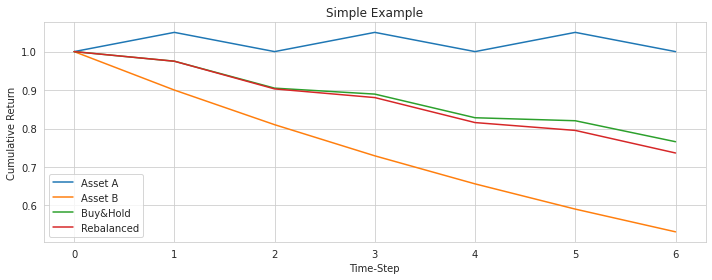

In [37]:
# Asset A returns have geo.mean 1 and Asset B returns are all 0.9
plot_simple_example(returns_a=np.tile([1.05, 1/1.05], 3),
                    returns_b=np.full(6, 0.9),
                    filename='Simple Example 1.svg');

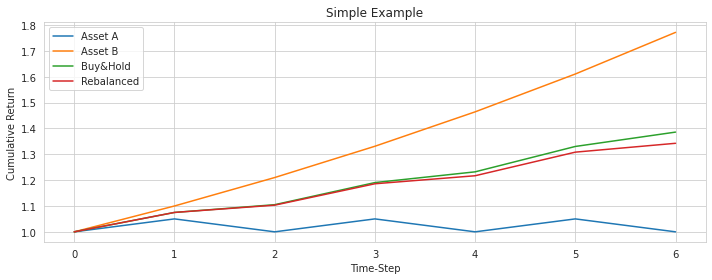

In [38]:
# Asset A returns have geo.mean 1 and Asset B returns are all 1.1
plot_simple_example(returns_a=np.tile([1.05, 1/1.05], 3),
                    returns_b=np.full(6, 1.1),
                    filename='Simple Example 2.svg');

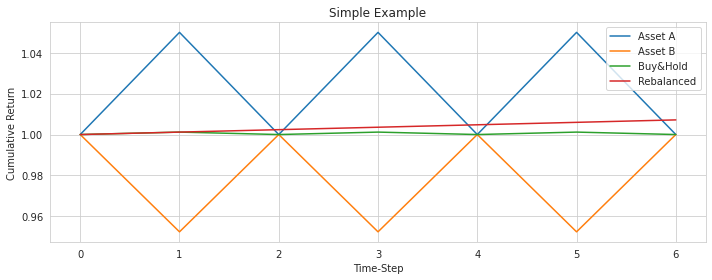

In [39]:
# Asset A and B returns both have geo.mean 1 and correlation -1
plot_simple_example(returns_a=np.tile([1.05, 1/1.05], 3),
                    returns_b=np.tile([1/1.05, 1.05], 3),
                    filename='Simple Example 3.svg');

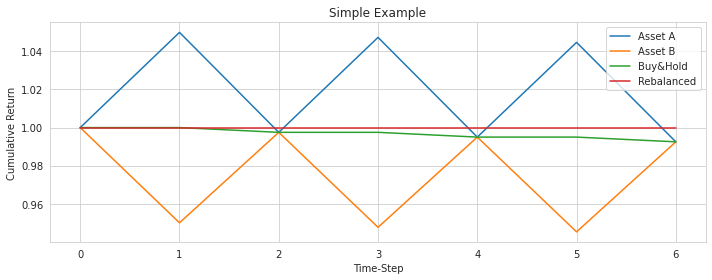

In [40]:
# Asset A and B returns both have arith.mean 1 and correlation -1
plot_simple_example(returns_a=np.tile([1.05, 0.95], 3),
                    returns_b=np.tile([0.95, 1.05], 3),
                    filename='Simple Example 4.svg');

## Daily Returns

Now produce all the plots and statistics for the daily stock-returns.

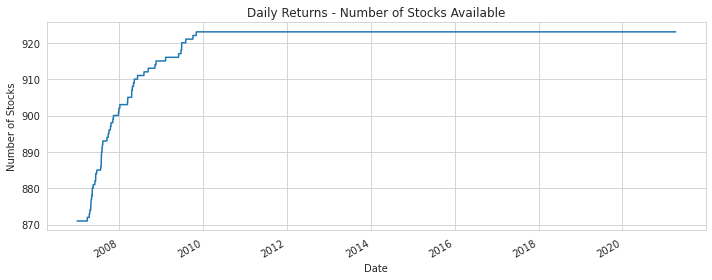

In [41]:
# Plot the number of available stocks with daily-returns.
plot_num_stocks(returns=daily_returns, returns_name=DAILY_RETURNS);

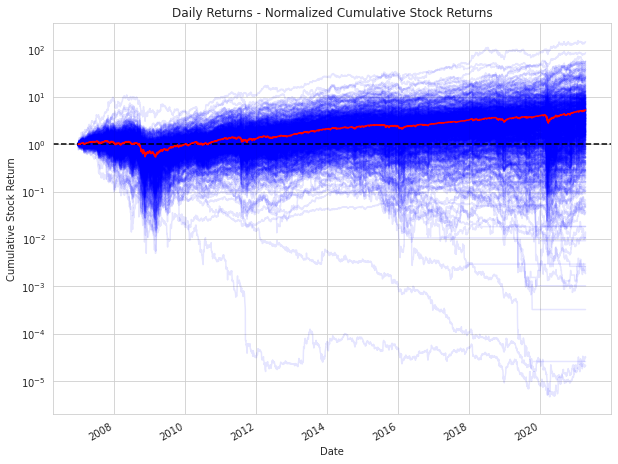

In [42]:
# Plot the normalized and cumulative returns of all stocks.
plot_all_stock_traces(returns=daily_returns,
                      returns_name=DAILY_RETURNS, logy=True);

Now create a large number of random portfolios, where each portfolio has a random selection of stock-tickers and a random sub-period. We plot the ratio between the Rebalanced portfolio value divided by the Buy&Hold portfolio value. A ratio above 1 means that the Rebalanced portfolio was best, while a ratio below 1 means that the Buy&Hold portfolio was best. As can be seen from these plots, there is no clear and consistent advantage to either the Rebalanced or Buy&Hold portfolios.

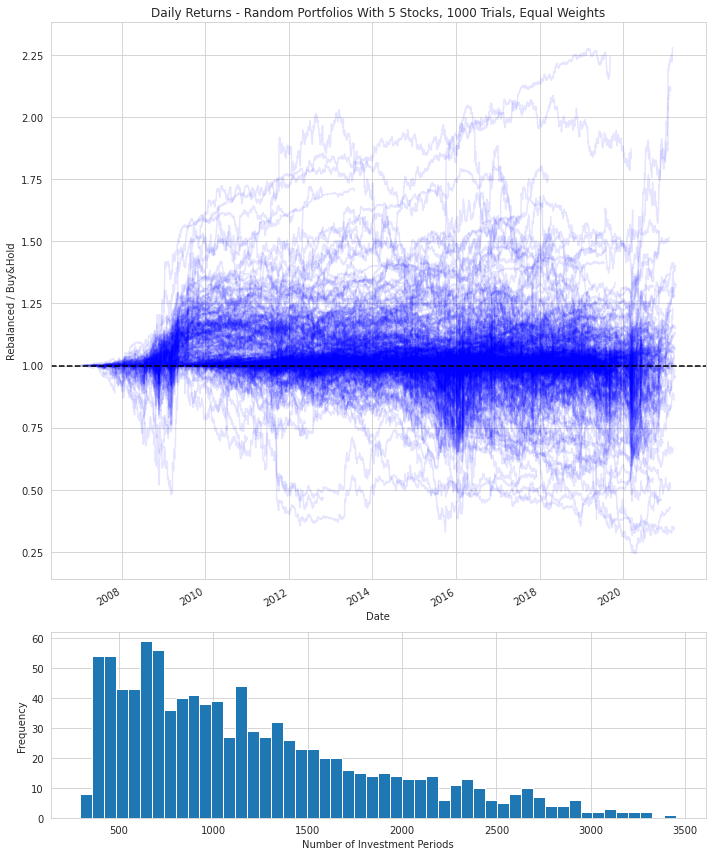

In [43]:
# Simulate and plot pandom portfolios with 5 stocks each.
sim_plot_portfolio_traces(returns=daily_returns,
                          returns_name=DAILY_RETURNS,
                          num_stocks=5, num_trials=1000,
                          random_weights=False);

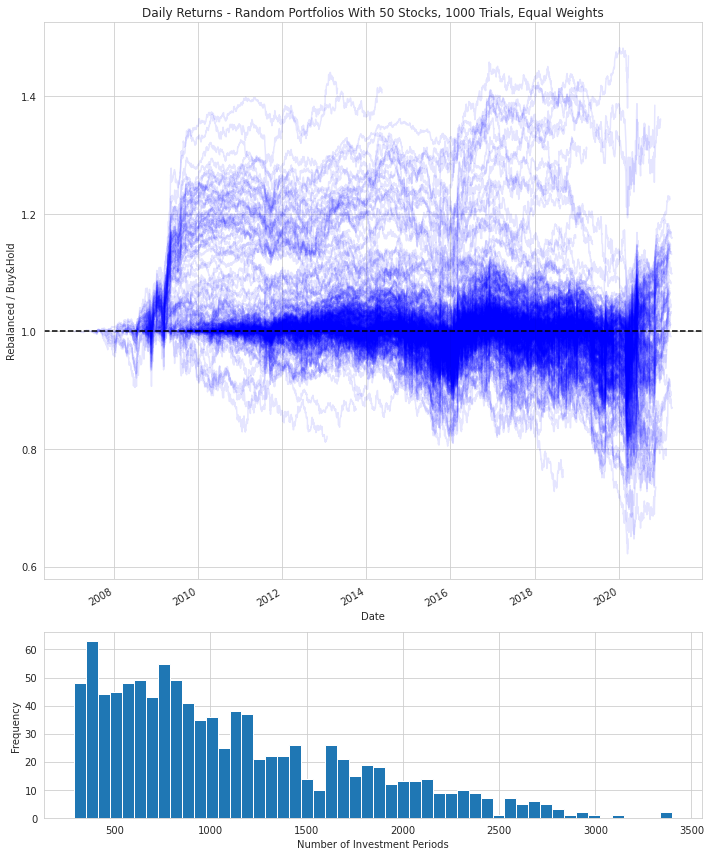

In [44]:
# Simulate and plot pandom portfolios with 50 stocks each.
sim_plot_portfolio_traces(returns=daily_returns,
                          returns_name=DAILY_RETURNS,
                          num_stocks=50, num_trials=1000,
                          random_weights=False);

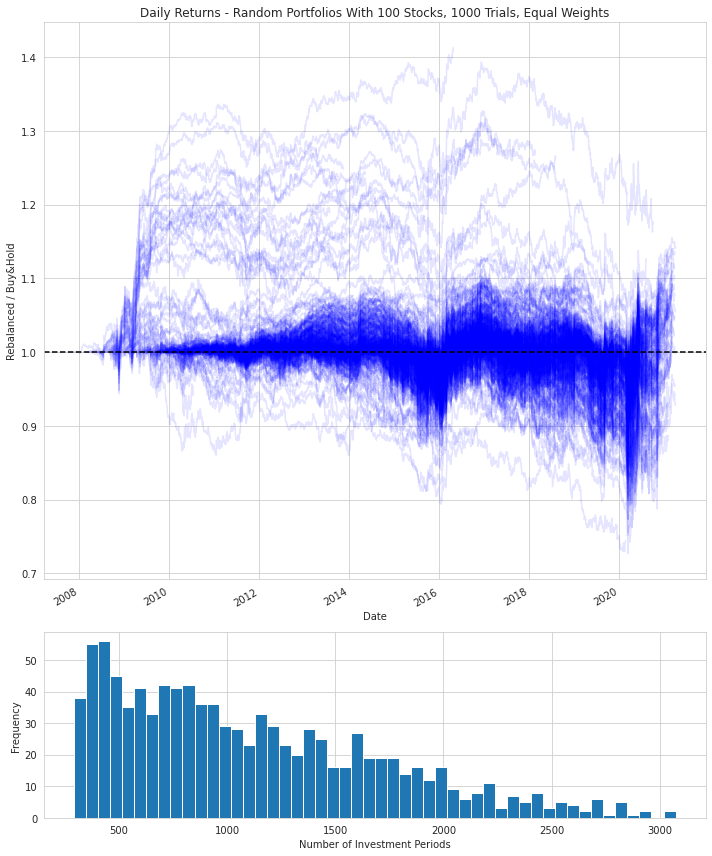

In [45]:
# Simulate and plot pandom portfolios with 100 stocks each.
sim_plot_portfolio_traces(returns=daily_returns,
                          returns_name=DAILY_RETURNS,
                          num_stocks=100, num_trials=1000,
                          random_weights=False);

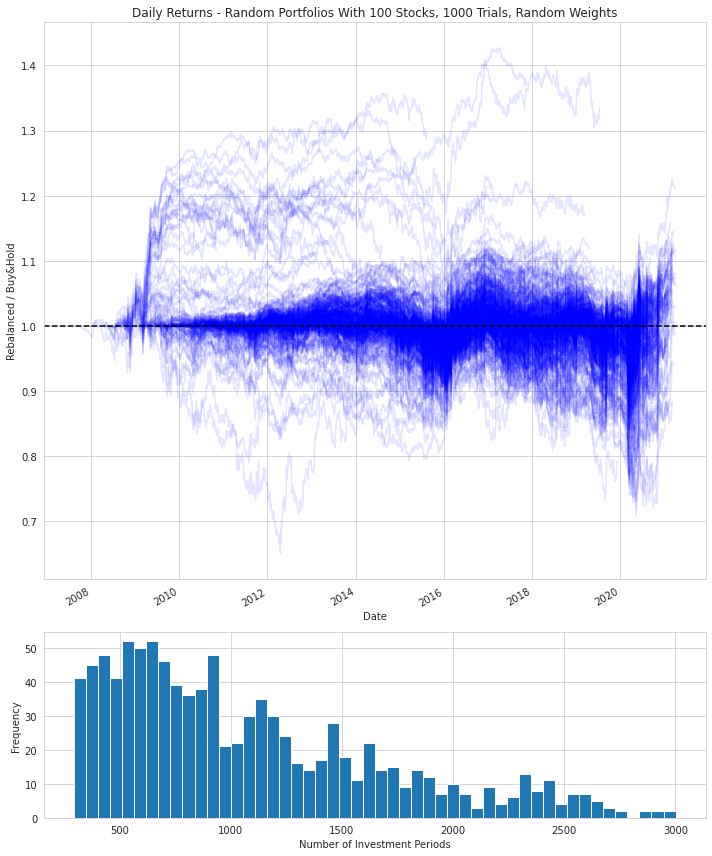

In [46]:
# Simulate and plot pandom portfolios with 100 stocks each.
# NOTE: This uses random weights instead of equal weights.
sim_plot_portfolio_traces(returns=daily_returns,
                          returns_name=DAILY_RETURNS,
                          num_stocks=100, num_trials=1000,
                          random_weights=True);

Now generate a large number of random portfolios with different choices for the number of stocks in each portfolio. Then plot all the various statistics to compare the performance of the Rebalanced and Buy&Hold portfolios for different choices of portfolio-size.

In [47]:
# Number of stocks to use in the random portfolio simulations.
num_stocks = [2, 5, 10, 20, 40, 60, 80, 100, 150, 200, 400]

CPU times: user 2min 9s, sys: 180 ms, total: 2min 9s
Wall time: 2min 8s


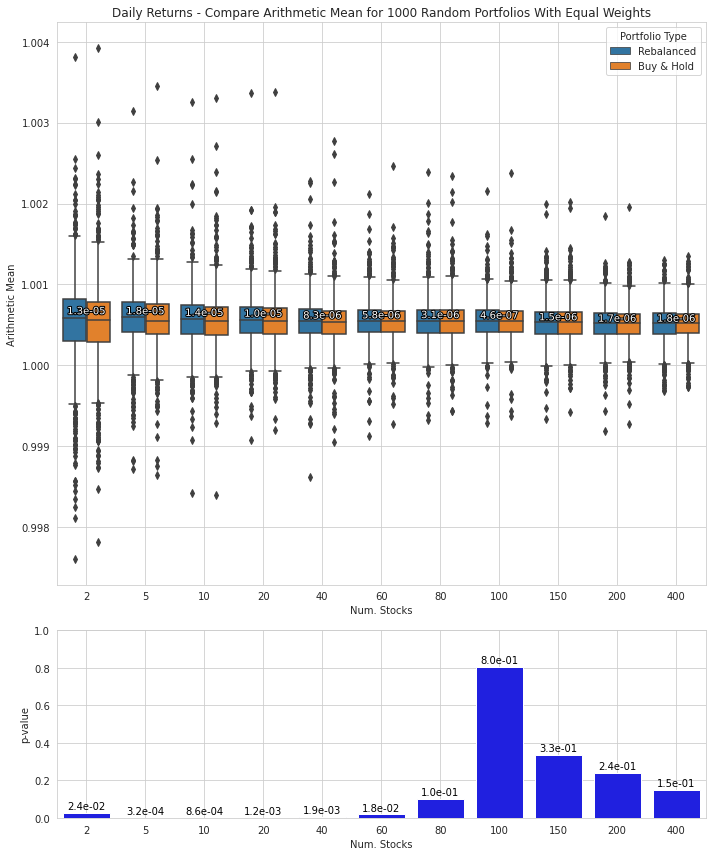

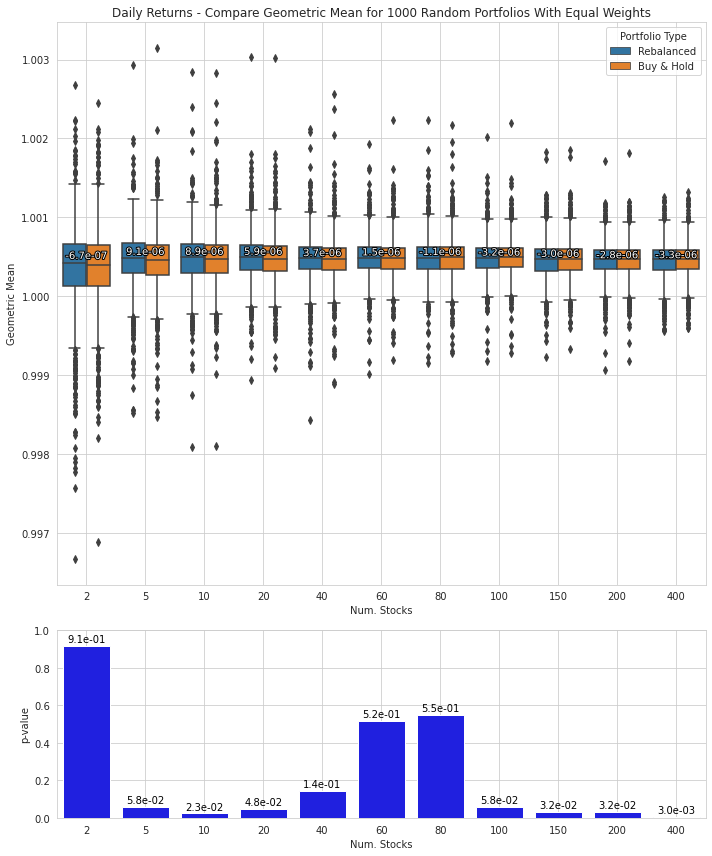

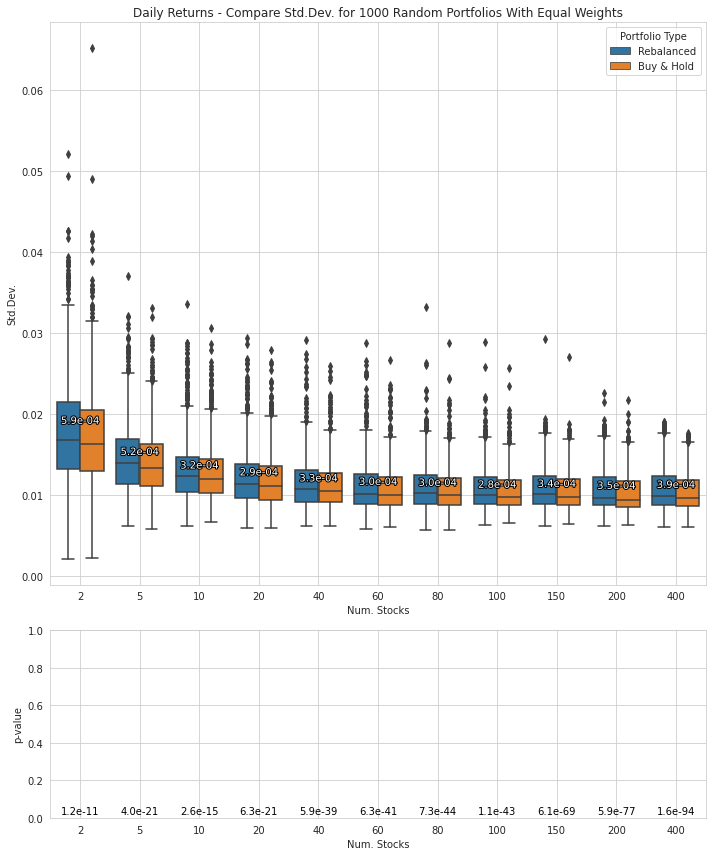

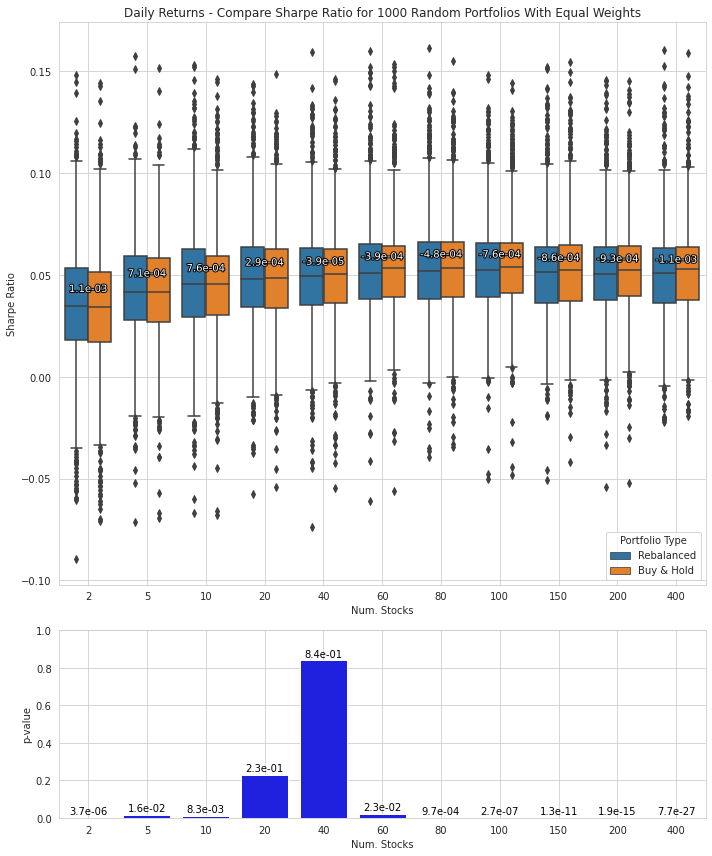

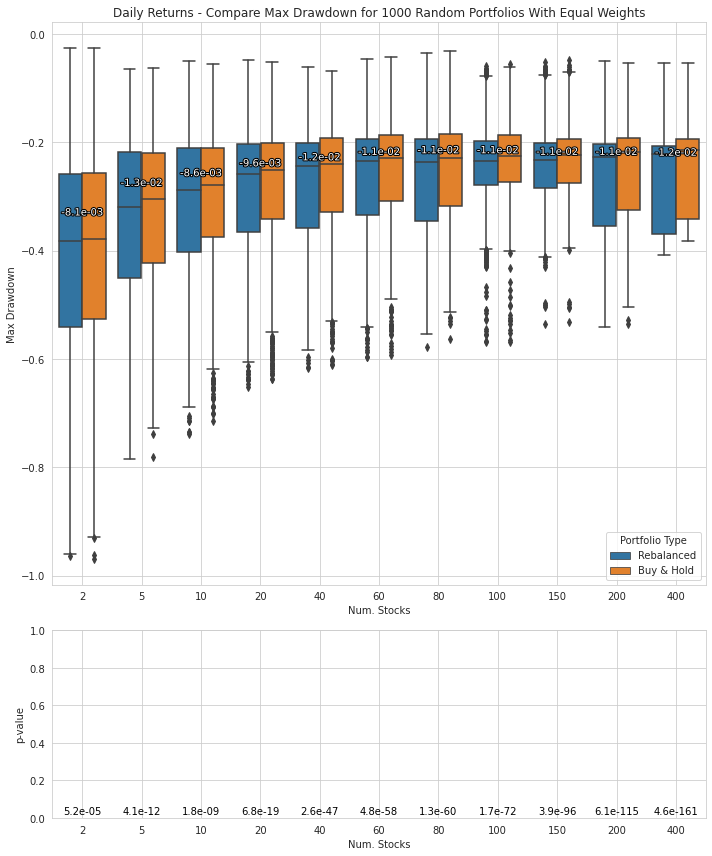

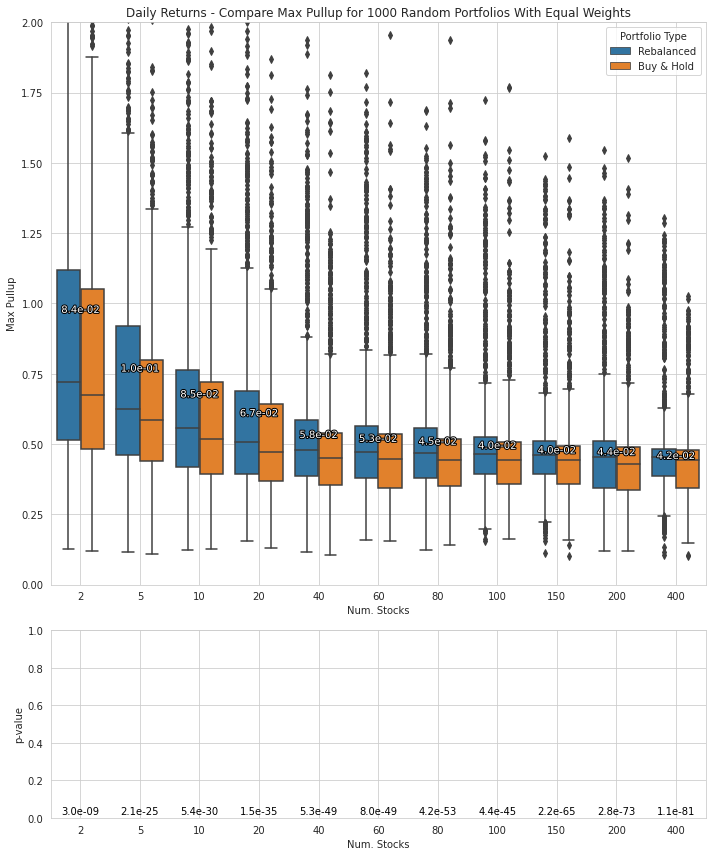

In [48]:
%%time
# Simulate random portfolios and plot all the statistics
# for comparing the Rebalanced and Buy&Hold portfolios.
sim_plot_compare_all(returns=daily_returns,
                     returns_name=DAILY_RETURNS,
                     num_stocks=num_stocks, num_trials=1000, 
                     random_weights=False,
                     pullup_window=int(BDAYS_PER_YEAR))

In [49]:
%%time
# Simulate random portfolios and plot all the statistics
# for comparing the Rebalanced and Buy&Hold portfolios.
# NOTE: This only uses the stock-returns TO the year 2010.
# The code is disabled because it overwrites the same output files.
if False:
    sim_plot_compare_all(returns=daily_returns[:'2010'],
                         returns_name=DAILY_RETURNS,
                         num_stocks=num_stocks, num_trials=1000, 
                         random_weights=False,
                         pullup_window=int(BDAYS_PER_YEAR))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [50]:
%%time
# Simulate random portfolios and plot all the statistics
# for comparing the Rebalanced and Buy&Hold portfolios.
# NOTE: This only uses the stock-returns FROM the year 2010.
# The code is disabled because it overwrites the same output files.
if False:
    sim_plot_compare_all(returns=daily_returns['2010':],
                         returns_name=DAILY_RETURNS,
                         num_stocks=num_stocks, num_trials=1000, 
                         random_weights=False,
                         pullup_window=int(BDAYS_PER_YEAR))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


## Weekly Returns

This is a simple resampling of the daily stock-data. You can manually set another "offset" so the resampling starts e.g. 1 or 2 days later, to see if that matters. Note that the "Max Drawdown" only uses the weekly data-points and does not consider the daily share-prices.

In [51]:
%%time
# Resample the daily returns into weekly returns.
weekly_returns = resample(returns=daily_returns,
                          offset=0, rule='1W')

CPU times: user 41.6 s, sys: 941 ms, total: 42.5 s
Wall time: 41 s


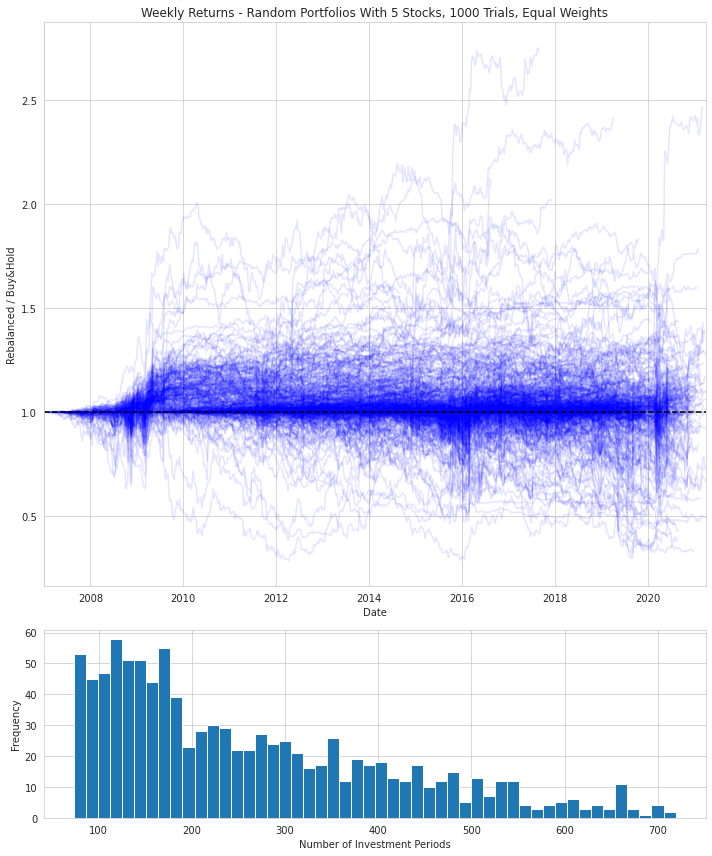

In [52]:
# Simulate and plot pandom portfolios with 5 stocks each.
sim_plot_portfolio_traces(returns=weekly_returns,
                          returns_name=WEEKLY_RETURNS,
                          num_stocks=5, num_trials=1000,
                          random_weights=False);

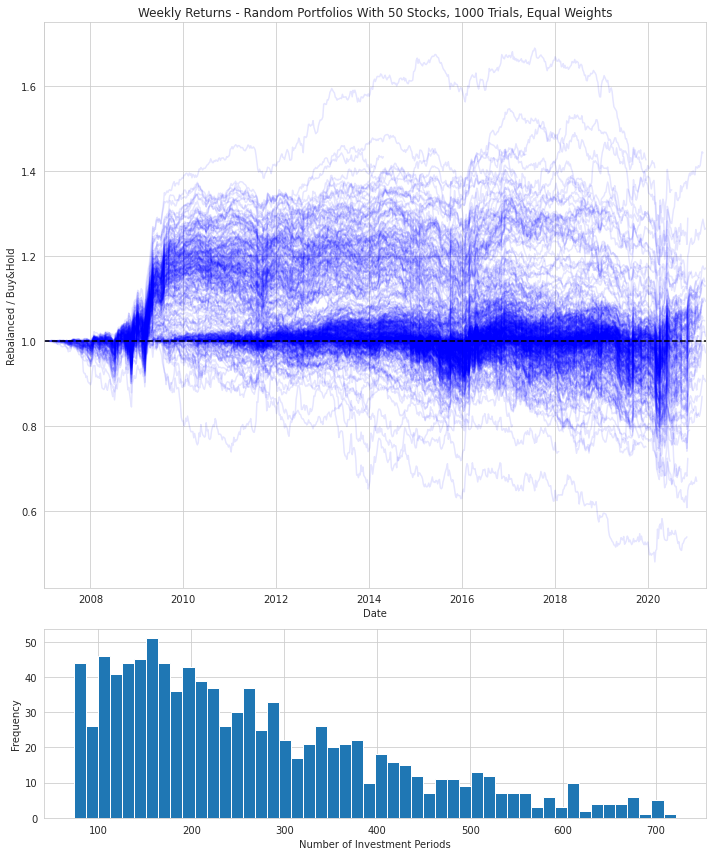

In [53]:
# Simulate and plot pandom portfolios with 50 stocks each.
sim_plot_portfolio_traces(returns=weekly_returns,
                          returns_name=WEEKLY_RETURNS,
                          num_stocks=50, num_trials=1000,
                          random_weights=False);

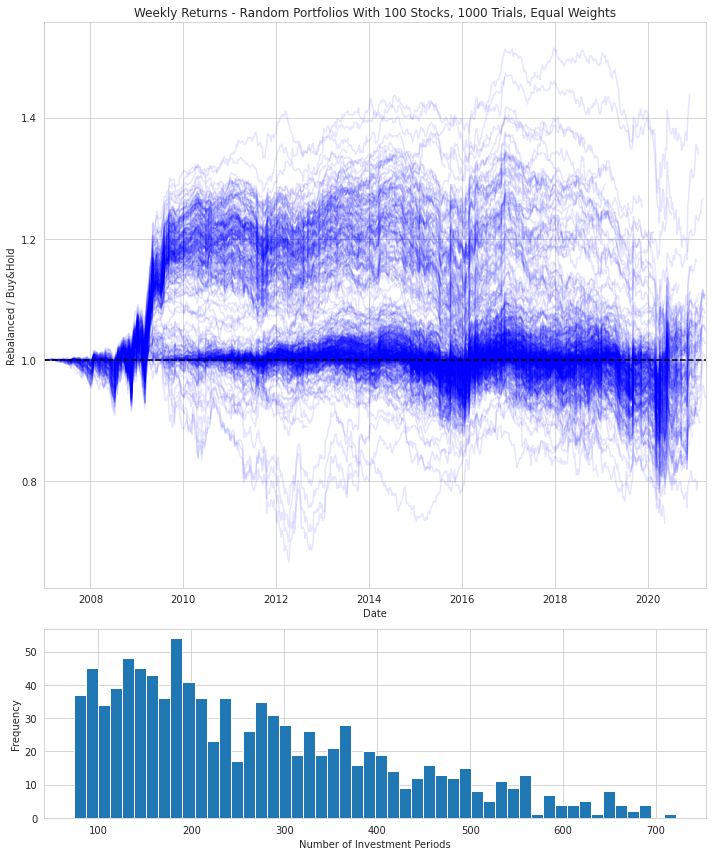

In [54]:
# Simulate and plot pandom portfolios with 100 stocks each.
sim_plot_portfolio_traces(returns=weekly_returns,
                          returns_name=WEEKLY_RETURNS,
                          num_stocks=100, num_trials=1000,
                          random_weights=False);

CPU times: user 1min 27s, sys: 78.9 ms, total: 1min 27s
Wall time: 1min 25s


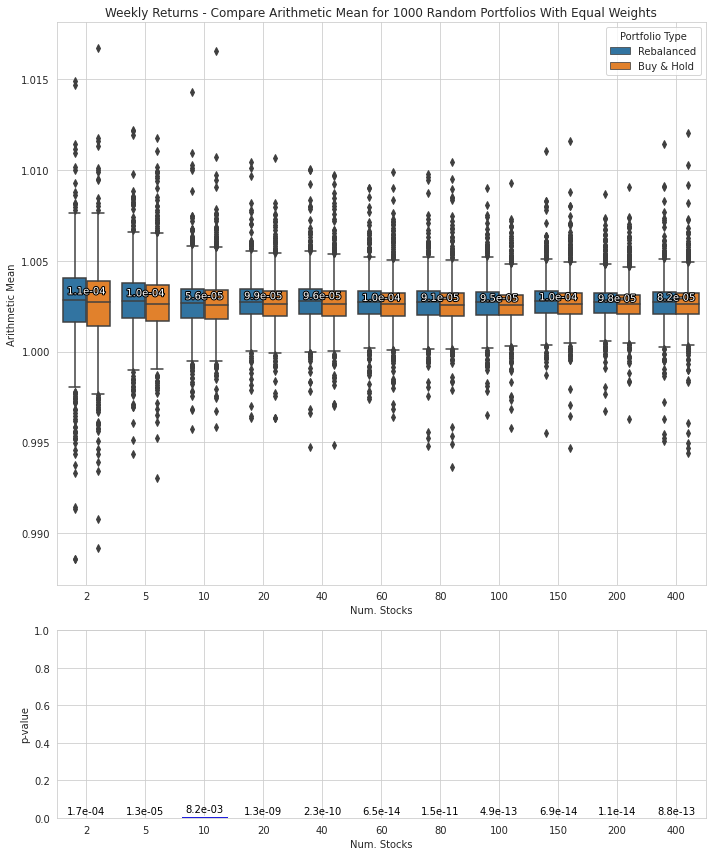

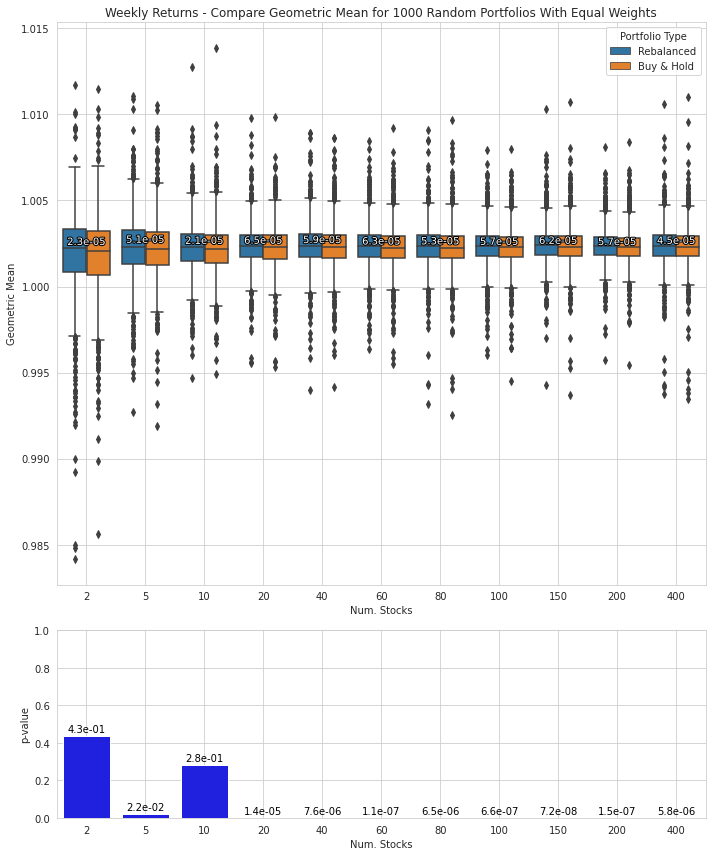

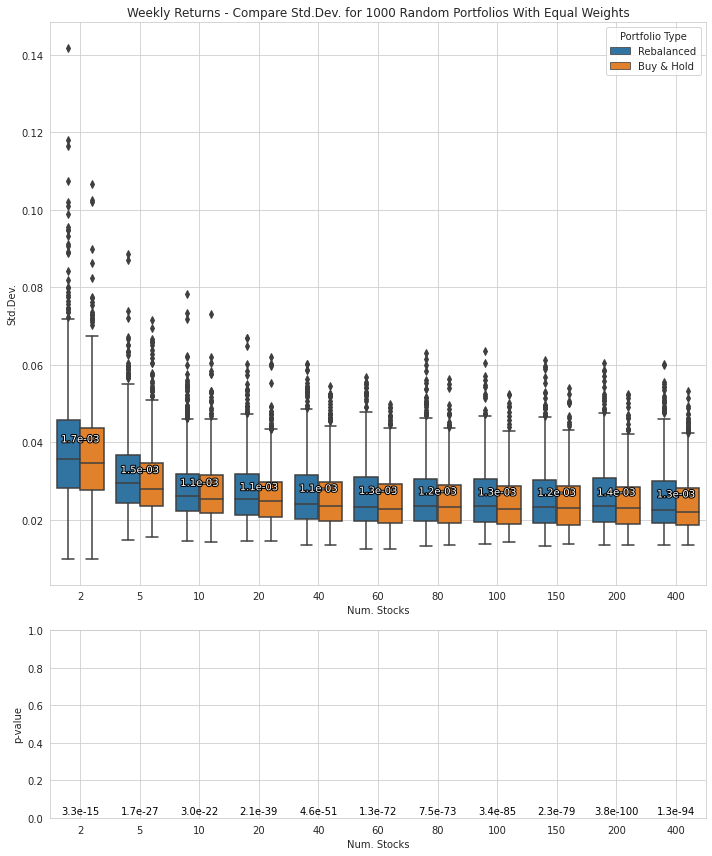

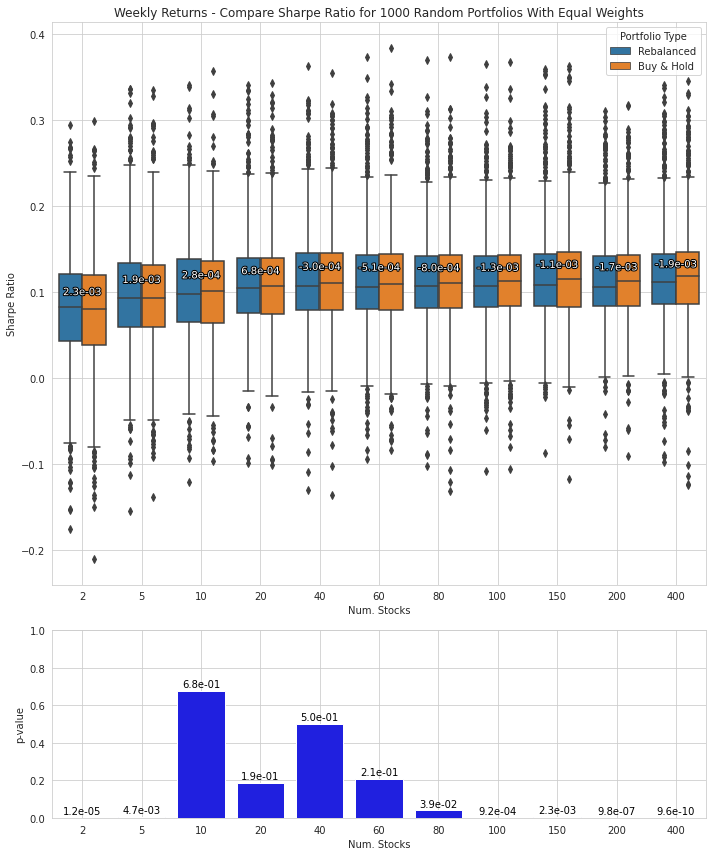

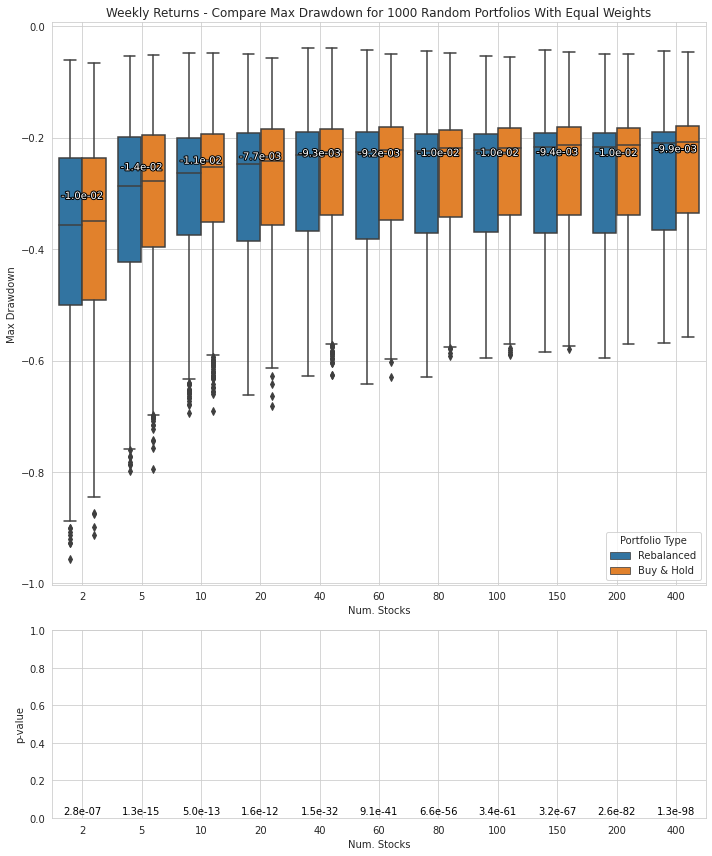

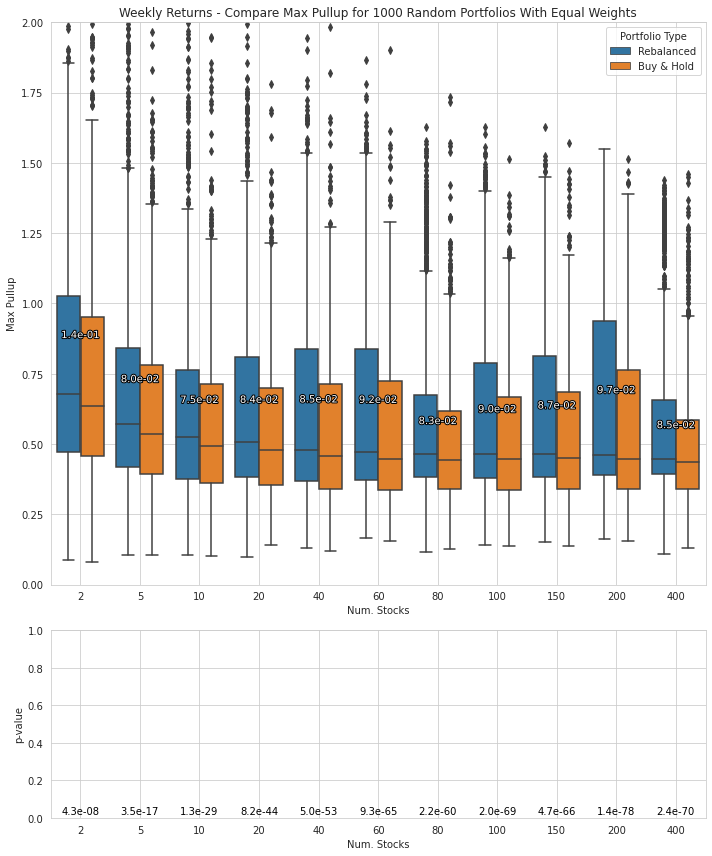

In [55]:
%%time
# Simulate random portfolios and plot all the statistics
# comparing the Rebalanced and Buy&Hold portfolios.
sim_plot_compare_all(returns=weekly_returns,
                     returns_name=WEEKLY_RETURNS,
                     num_stocks=num_stocks, num_trials=1000, 
                     random_weights=False, pullup_window=52)

In [56]:
%%time
# Simulate random portfolios and plot all the statistics
# comparing the Rebalanced and Buy&Hold portfolios.
# NOTE: This only uses the stock-returns TO the year 2010.
# The code is disabled because it overwrites the same output files.
if False:
    sim_plot_compare_all(returns=weekly_returns[:'2010'],
                         returns_name=WEEKLY_RETURNS,
                         num_stocks=num_stocks, num_trials=1000, 
                         random_weights=False, pullup_window=52)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [57]:
%%time
# Simulate random portfolios and plot all the statistics
# comparing the Rebalanced and Buy&Hold portfolios.
# NOTE: This only uses the stock-returns FROM the year 2010.
# The code is disabled because it overwrites the same output files.
if False:
    sim_plot_compare_all(returns=weekly_returns['2010':],
                         returns_name=WEEKLY_RETURNS,
                         num_stocks=num_stocks, num_trials=1000, 
                         random_weights=False, pullup_window=52)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


## Monthly Returns

This is a simple resampling of the daily stock-data. You can manually set another "offset" so the resampling starts e.g. 1 or 2 days later, to see if that matters. Note that the "Max Drawdown" only uses the monthly data-points and does not consider the daily share-prices.

In [58]:
%%time
# Resample the daily returns into monthly returns.
monthly_returns = resample(returns=daily_returns,
                           offset=0, rule='1M')

CPU times: user 9.79 s, sys: 80.4 ms, total: 9.87 s
Wall time: 9.74 s


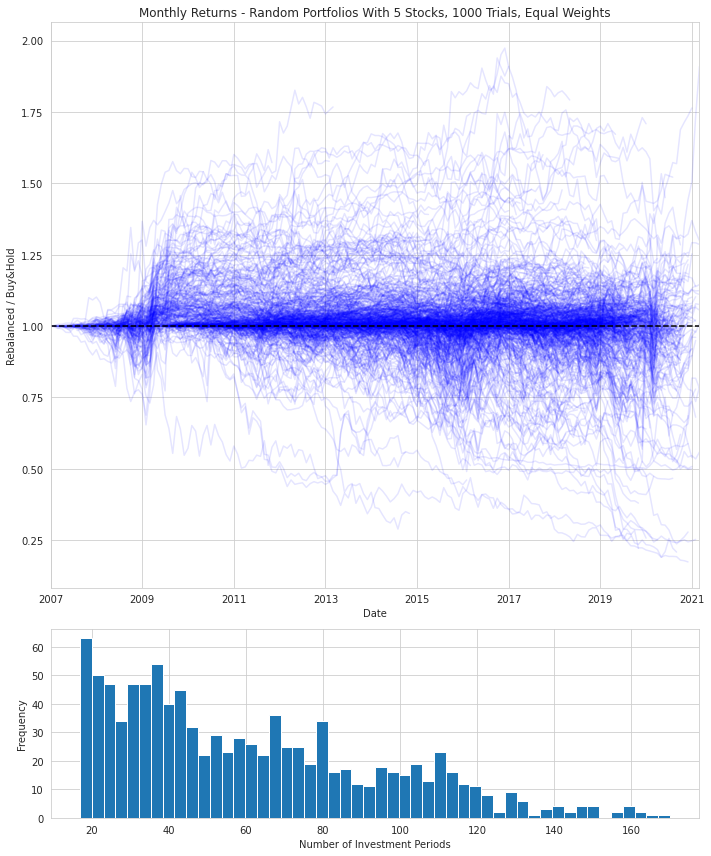

In [59]:
# Simulate and plot pandom portfolios with 5 stocks each.
sim_plot_portfolio_traces(returns=monthly_returns,
                          returns_name=MONTHLY_RETURNS,
                          num_stocks=5, num_trials=1000,
                          random_weights=False);

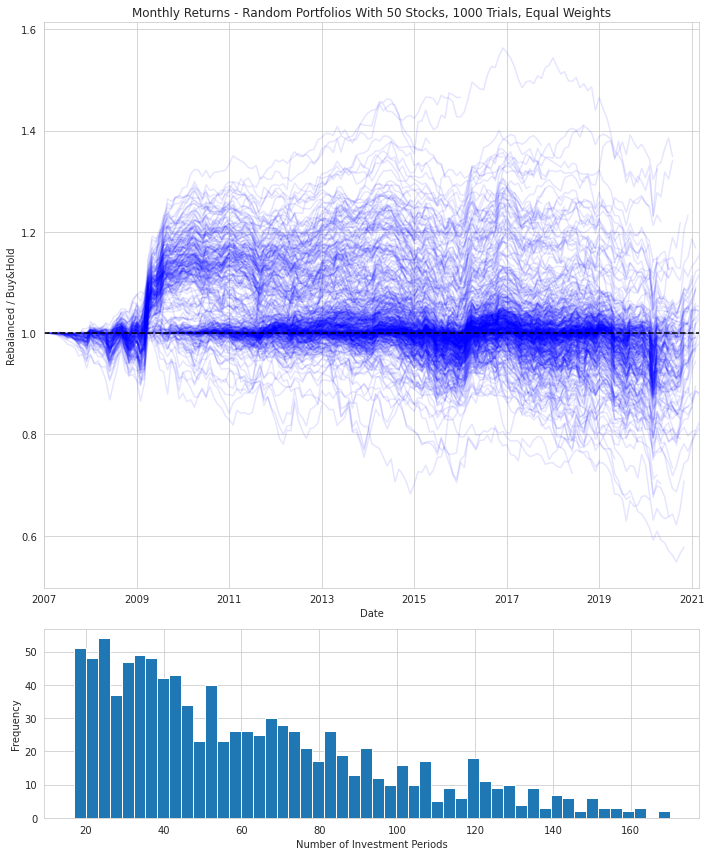

In [60]:
# Simulate and plot pandom portfolios with 50 stocks each.
sim_plot_portfolio_traces(returns=monthly_returns,
                          returns_name=MONTHLY_RETURNS,
                          num_stocks=50, num_trials=1000,
                          random_weights=False);

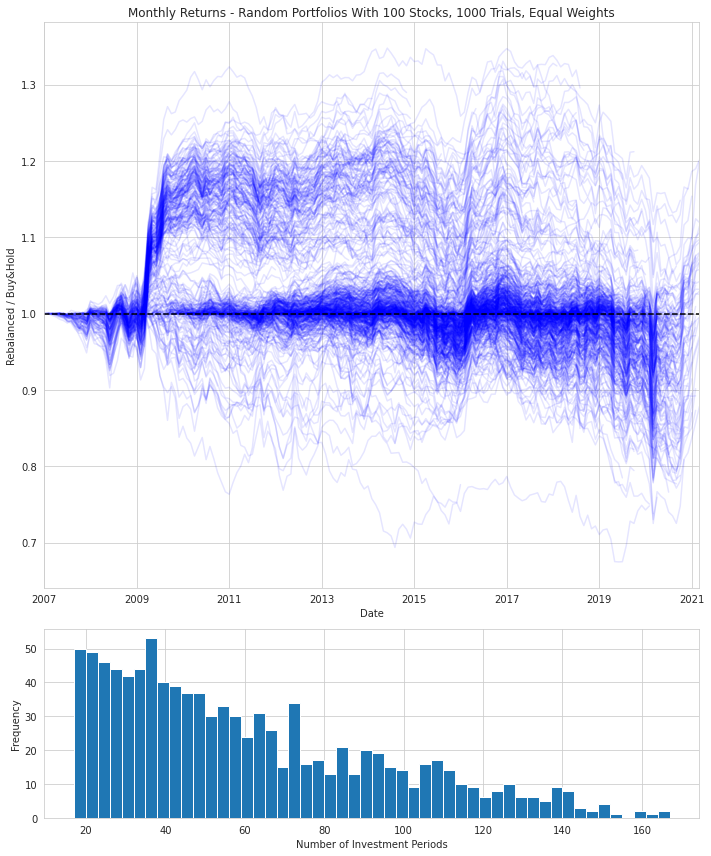

In [61]:
# Simulate and plot pandom portfolios with 100 stocks each.
sim_plot_portfolio_traces(returns=monthly_returns,
                          returns_name=MONTHLY_RETURNS,
                          num_stocks=100, num_trials=1000,
                          random_weights=False);

CPU times: user 1min 17s, sys: 244 ms, total: 1min 17s
Wall time: 1min 16s


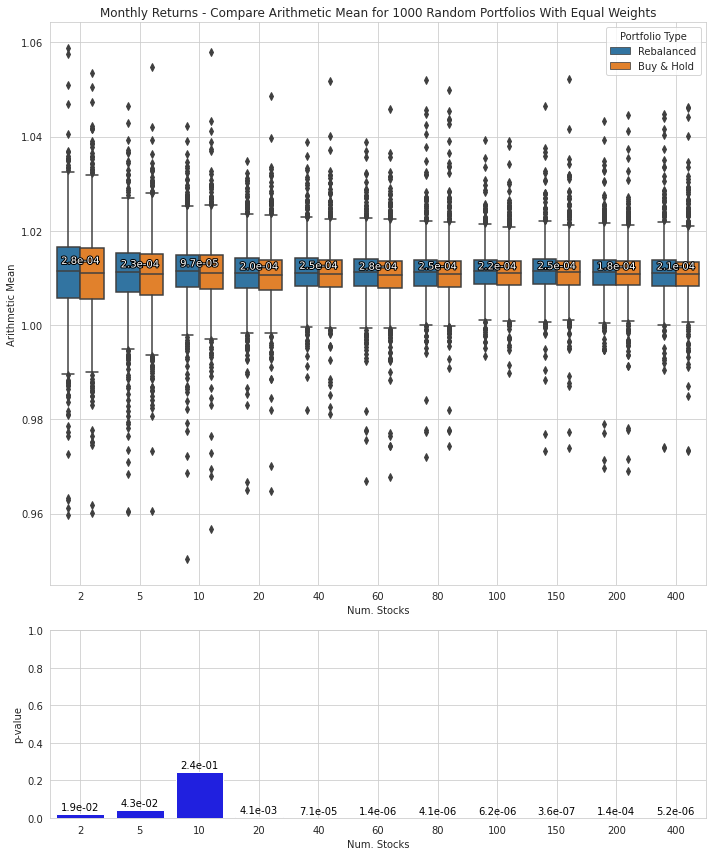

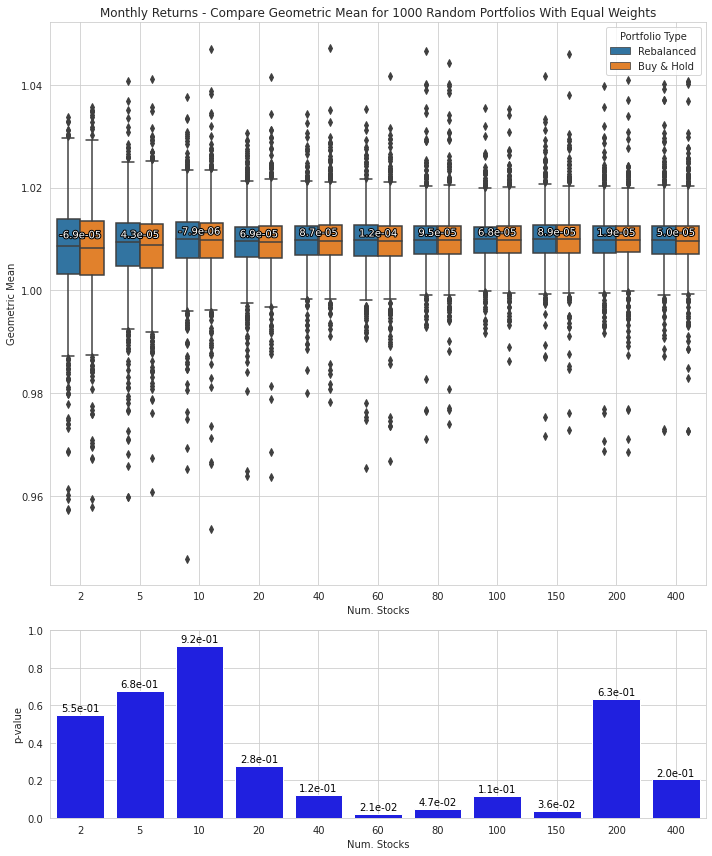

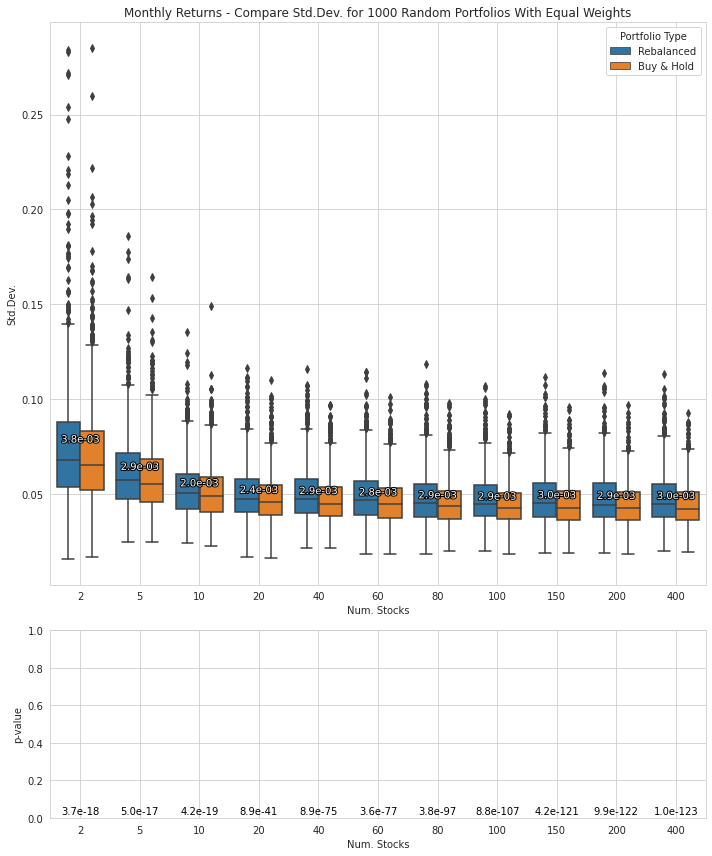

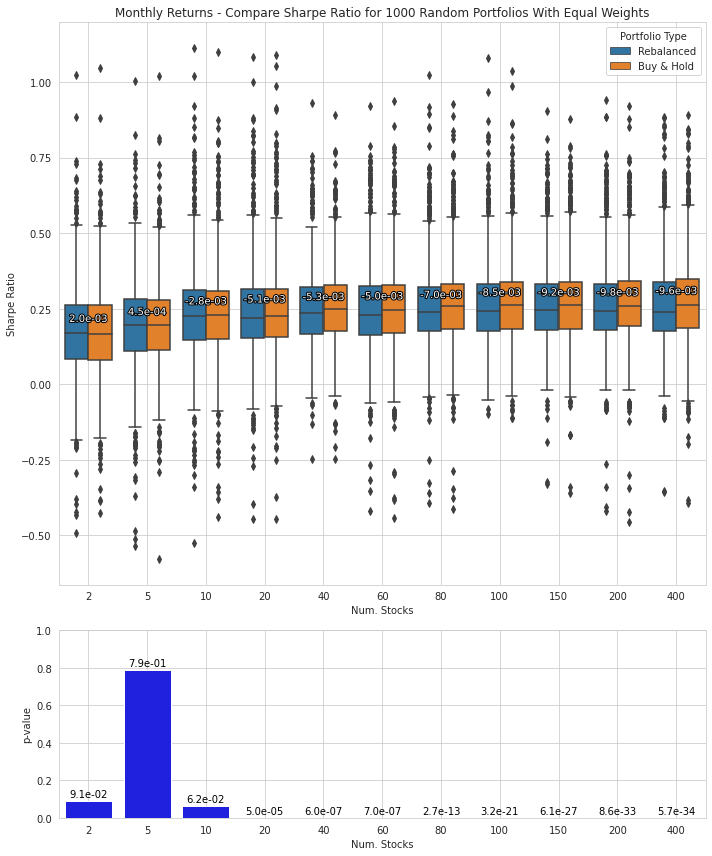

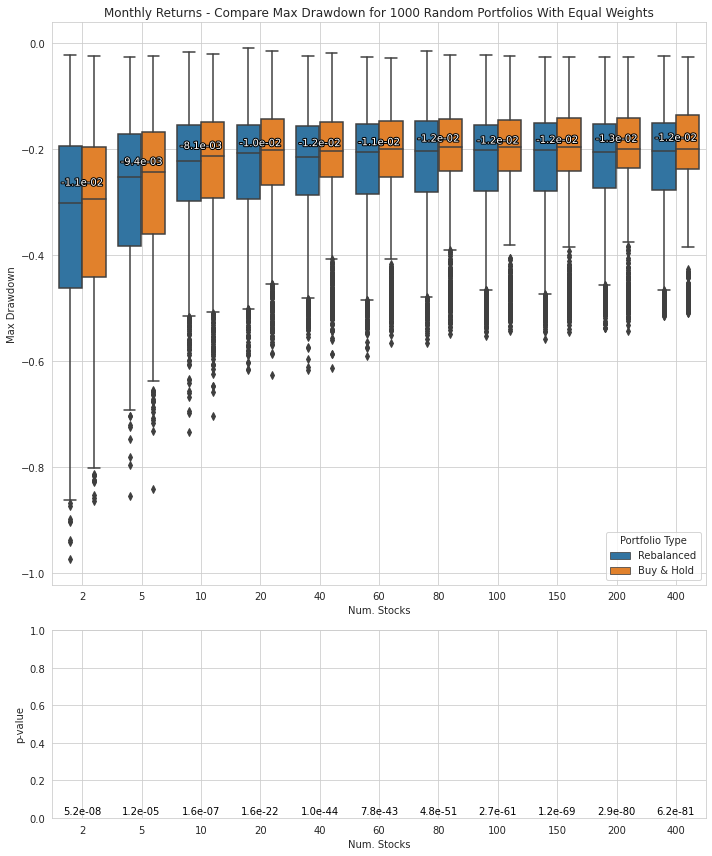

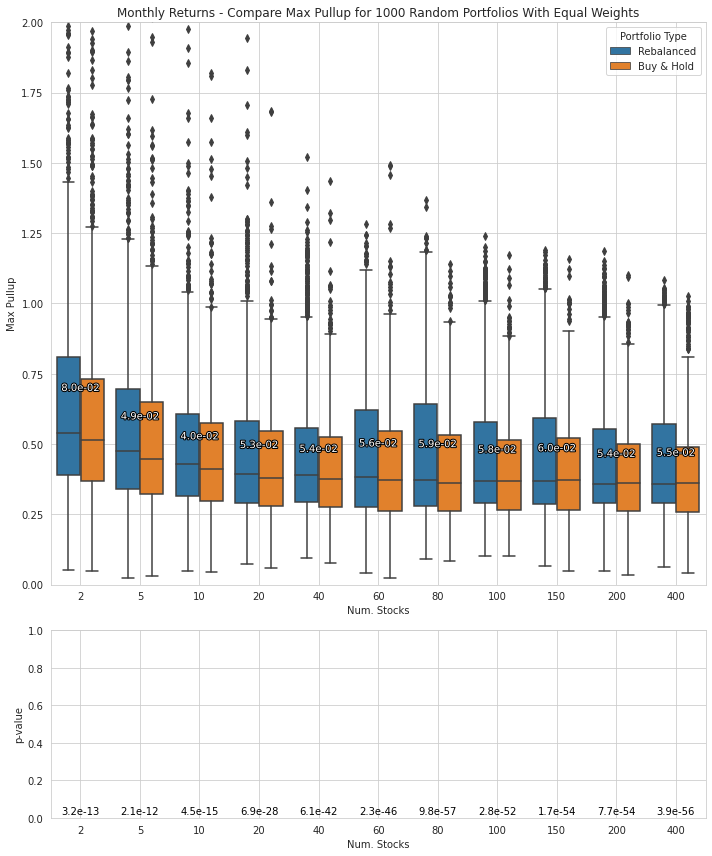

In [62]:
%%time
# Simulate random portfolios and plot all the statistics
# comparing the Rebalanced and Buy&Hold portfolios.
sim_plot_compare_all(returns=monthly_returns,
                     returns_name=MONTHLY_RETURNS,
                     num_stocks=num_stocks, num_trials=1000, 
                     random_weights=False, pullup_window=12)

In [63]:
%%time
# Simulate random portfolios and plot all the statistics
# comparing the Rebalanced and Buy&Hold portfolios.
# NOTE: This only uses the stock-returns TO the year 2010.
# The code is disabled because it overwrites the same output files.
if False:
    sim_plot_compare_all(returns=monthly_returns[:'2010'],
                         returns_name=MONTHLY_RETURNS,
                         num_stocks=num_stocks, num_trials=1000, 
                         random_weights=False, pullup_window=12)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [64]:
%%time
# Simulate random portfolios and plot all the statistics
# comparing the Rebalanced and Buy&Hold portfolios.
# NOTE: This only uses the stock-returns FROM the year 2010.
# The code is disabled because it overwrites the same output files.
if False:
    sim_plot_compare_all(returns=monthly_returns['2010':],
                         returns_name=MONTHLY_RETURNS,
                         num_stocks=num_stocks, num_trials=1000, 
                         random_weights=False, pullup_window=12)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


## Annual Returns

This is a simple resampling of the daily stock-data. You can manually set another "offset" so the resampling starts e.g. 1 or 2 days later, to see if that matters. Note that the "Max Drawdown" only uses the annual data-points and does not consider the daily share-prices.

In [65]:
%%time
# Resample the daily returns into annual returns.
annual_returns = resample(returns=daily_returns,
                          offset=0, rule='1Y')

CPU times: user 1.78 s, sys: 28.7 ms, total: 1.81 s
Wall time: 1.7 s


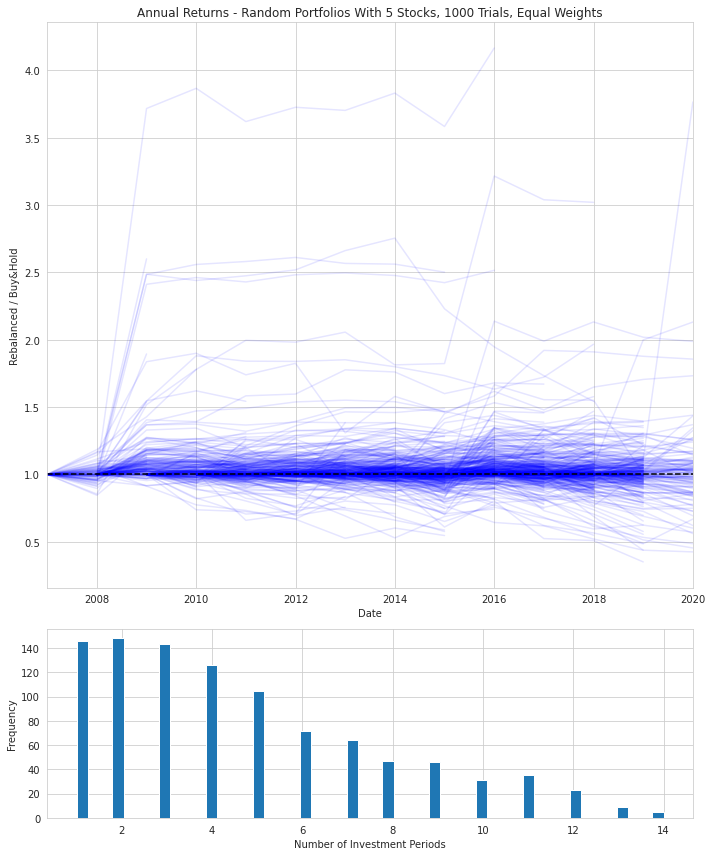

In [66]:
# Simulate and plot pandom portfolios with 5 stocks each.
sim_plot_portfolio_traces(returns=annual_returns,
                          returns_name=ANNUAL_RETURNS,
                          num_stocks=5, num_trials=1000,
                          random_weights=False);

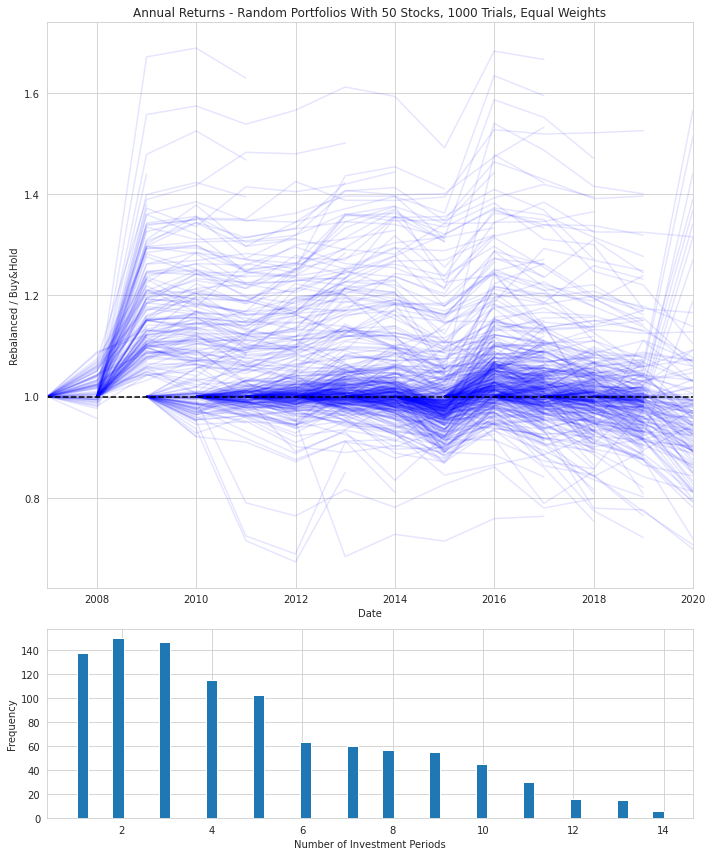

In [67]:
# Simulate and plot pandom portfolios with 50 stocks each.
sim_plot_portfolio_traces(returns=annual_returns,
                          returns_name=ANNUAL_RETURNS,
                          num_stocks=50, num_trials=1000,
                          random_weights=False);

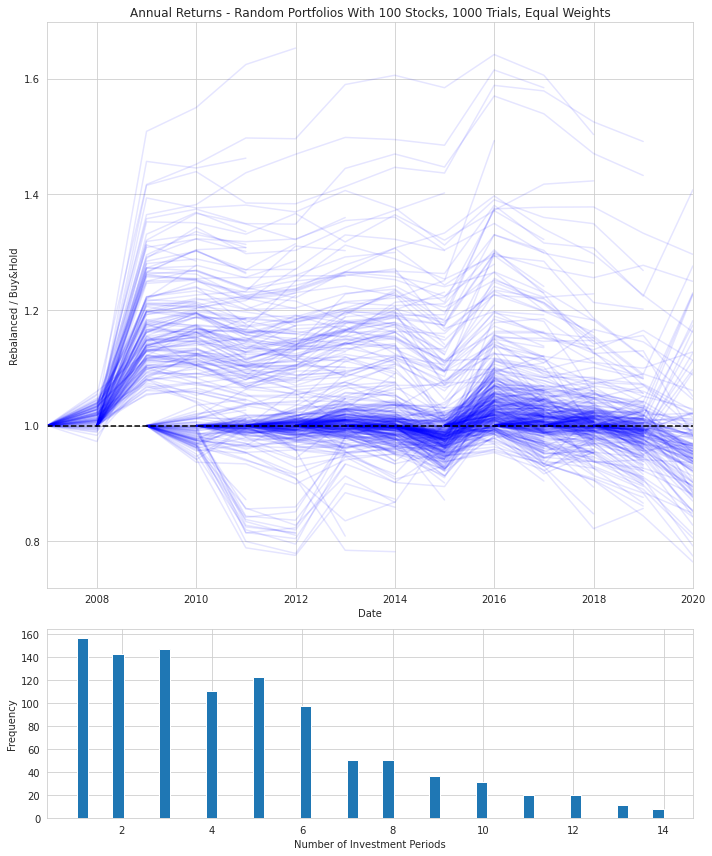

In [68]:
# Simulate and plot pandom portfolios with 100 stocks each.
sim_plot_portfolio_traces(returns=annual_returns,
                          returns_name=ANNUAL_RETURNS,
                          num_stocks=100, num_trials=1000,
                          random_weights=False);

CPU times: user 1min 12s, sys: 380 ms, total: 1min 12s
Wall time: 1min 11s


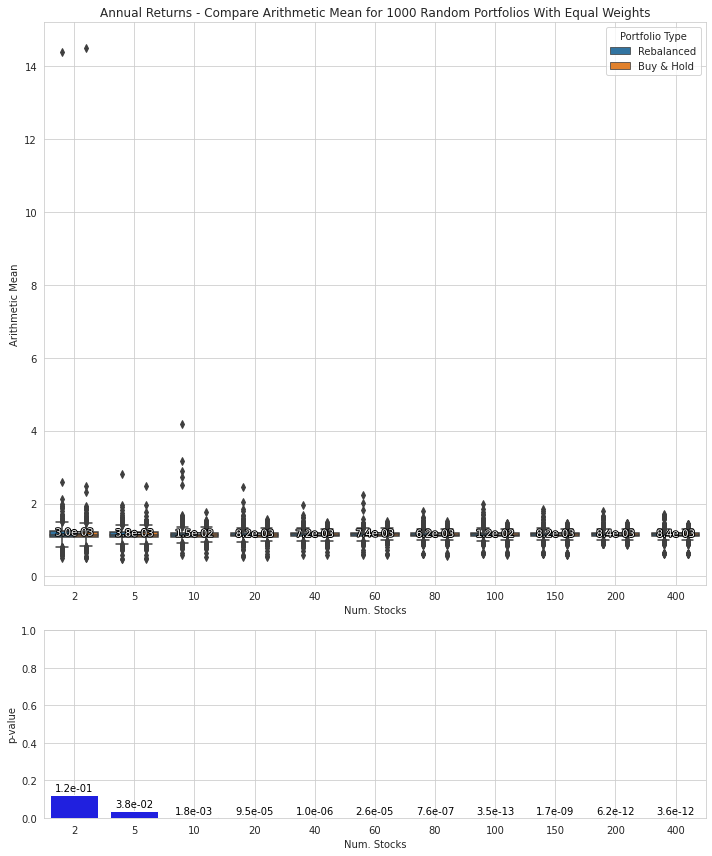

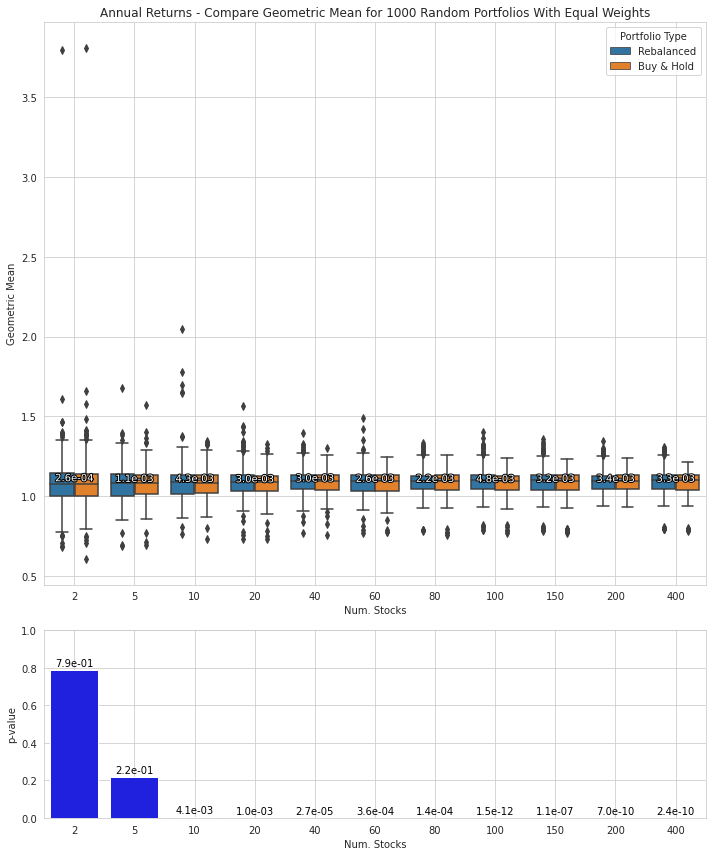

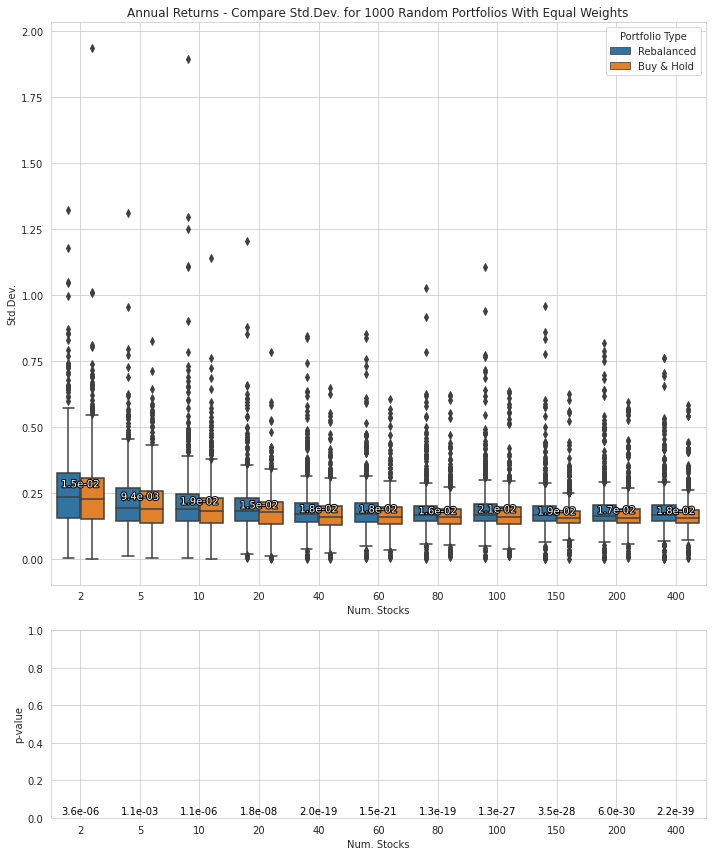

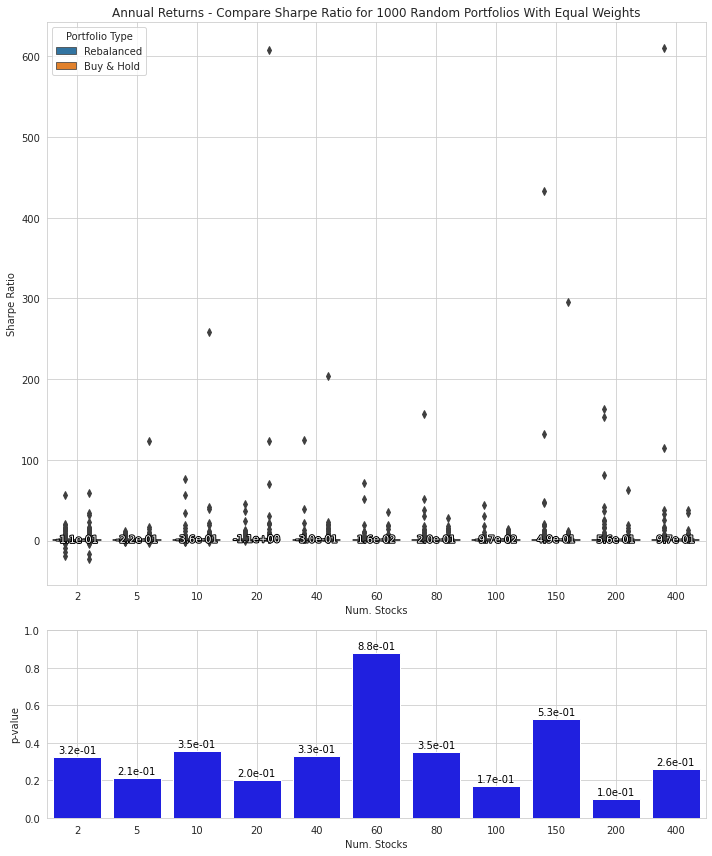

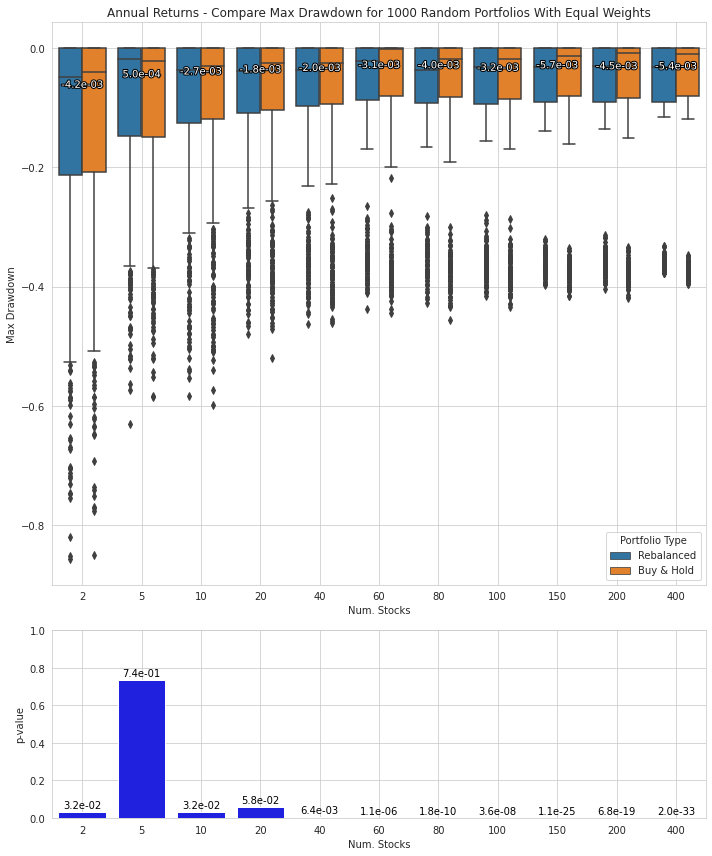

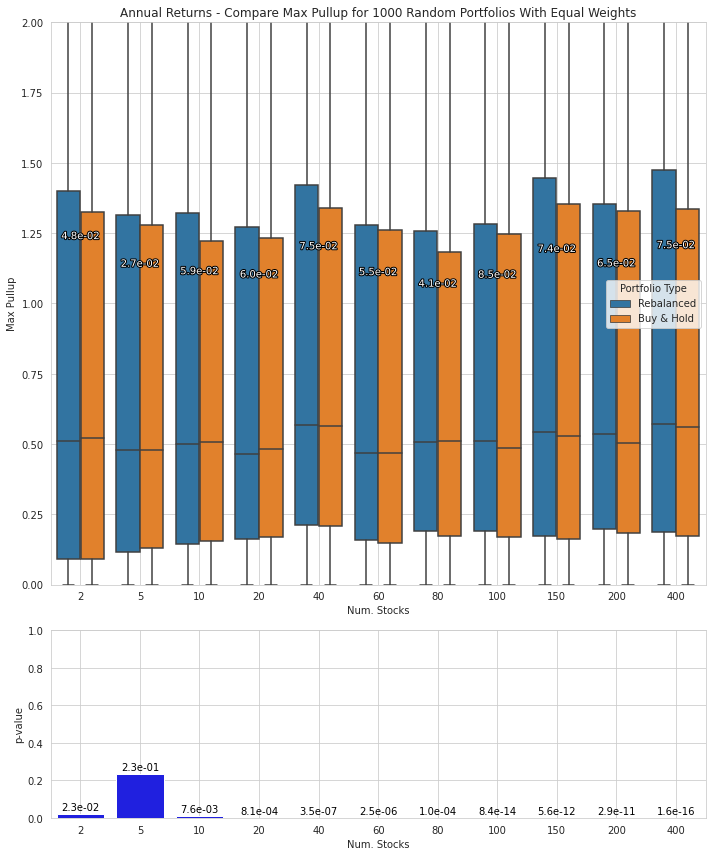

In [69]:
%%time
# These are probably not very useful because there are only
# 14 annual data-points for each stock in this data-set.
sim_plot_compare_all(returns=annual_returns,
                     returns_name=ANNUAL_RETURNS,
                     num_stocks=num_stocks, num_trials=1000, 
                     random_weights=False)

## Load and Process Intraday Data

The intraday share-prices can be downloaded from [AlphaVantage](https://www.alphavantage.co/) with a free API key that you can obtain from their web-site.

In [70]:
# List of the stock-tickers that we want intraday data for.
all_tickers_intraday = \
    ['AAPL', 'ADBE', 'ADM', 'AEP', 'AMZN', 'APD', 'ATVI', 'BLL',
     'CL', 'CMG', 'CMI', 'CVX', 'DIS', 'DOV', 'DTE', 'DUK', 'EBAY',
     'ED', 'EMR', 'ETR', 'FDX', 'GLW', 'HAL', 'HD', 'HON', 'IFF',
     'INTC', 'IP', 'ITW', 'JCI', 'KMX', 'KO', 'MAR', 'MAS', 'MCD',
     'MCO', 'MMM', 'MRK', 'MSFT', 'MSI', 'NFLX', 'NKE', 'NOC', 'NSC',
     'PAYX', 'PEP', 'PFE', 'PG', 'PH', 'PM', 'ROK', 'SBUX', 'SCHW',
     'SHW', 'SLB', 'SWK', 'T', 'TAP', 'TJX', 'TMO', 'TSN', 'TXN',
     'UNP', 'UPS', 'VFC', 'WAT', 'WMB', 'WMT', 'WU', 'XOM']

In [71]:
%%time
# Download the intraday share-prices. This takes about 1 hour
# if you are using a free API key, because AlphaVantage only
# allows 5 free API calls per minute.
if False:
    # Load API key for Alpha Vantage from a text-file.
    # You can set another path for the text-file.
    load_api_key_av()

    # Download 1-min intraday share-prices.
    download_shareprices_intraday(tickers=all_tickers_intraday,
                                  interval='1min')
    
    # Download 5-min intraday share-prices.
    download_shareprices_intraday(tickers=all_tickers_intraday,
                                  interval='5min')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [72]:
%%time
# Load 1-min intraday share-prices into a Pandas DataFrame.
df_1min = load_shareprices_intraday(tickers=all_tickers_intraday,
                                    interval='1min')
intraday_1min_prices = df_1min[CLOSE].unstack().T

# Load 5-min intraday share-prices into a Pandas DataFrame.
df_5min = load_shareprices_intraday(tickers=all_tickers_intraday,
                                    interval='5min')
intraday_5min_prices = df_5min[CLOSE].unstack().T

CPU times: user 807 ms, sys: 3.99 ms, total: 811 ms
Wall time: 810 ms


In [73]:
# Valid tickers for intraday stock-data, in case of missing data
# these lists may be different from all_tickers_intraday
valid_tickers_intraday_1min = intraday_1min_prices.columns.to_list()
valid_tickers_intraday_5min = intraday_5min_prices.columns.to_list()

In [74]:
# Show how many valid tickers we have intraday data for.
print(len(valid_tickers_intraday_1min))
print(len(valid_tickers_intraday_5min))

70
70


In [75]:
# Only use data-points for when the stock-markets are open,
# because the sampling frequency is irregular outside of normal
# trading hours, which may cause problems for the rebalancing.
start_time = '9:30'
end_time = '16:00'
intraday_1min_prices = \
    intraday_1min_prices.between_time(start_time=start_time,
                                      end_time=end_time)
intraday_5min_prices = \
    intraday_5min_prices.between_time(start_time=start_time,
                                      end_time=end_time)

In [76]:
# When calculating stock-returns for intraday periods, we are
# forward-filling the data in case of missing data-points.
# This is particularly a problem with data-points outside of normal
# trading-hours, but it may also occur during normal trading-hours
# if a stock is thinly traded. It creates a problem for the
# rebalancing algorithm, which assumes that the stocks are fully
# liquid, so it can always rebalance between all stocks. This may
# give incorrect results if the rebalancing was not actually
# possible. But these particular stocks should have most
# data-points available during normal trading-hours.

# Calculate stock-returns for all 1-minute periods.
intraday_1min_returns = \
    intraday_1min_prices.ffill().pct_change().dropna() + 1.0

# Calculate stock-returns for all 5-minute periods.
intraday_5min_returns = \
    intraday_5min_prices.ffill().pct_change().dropna() + 1.0

## Intraday Returns 1-Min

Now make all the plots for intraday stock-returns with 1-minute intervals.

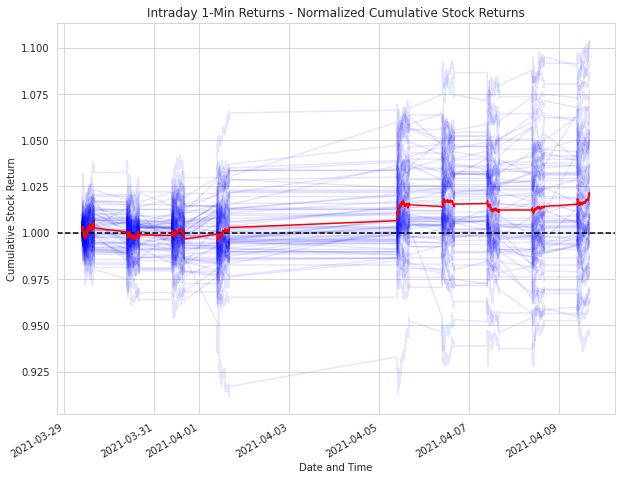

In [77]:
# Plot the normalized and cumulative returns of all stocks.
plot_all_stock_traces(returns=intraday_1min_returns,
                      returns_name=INTRADAY_1MIN_RETURNS);

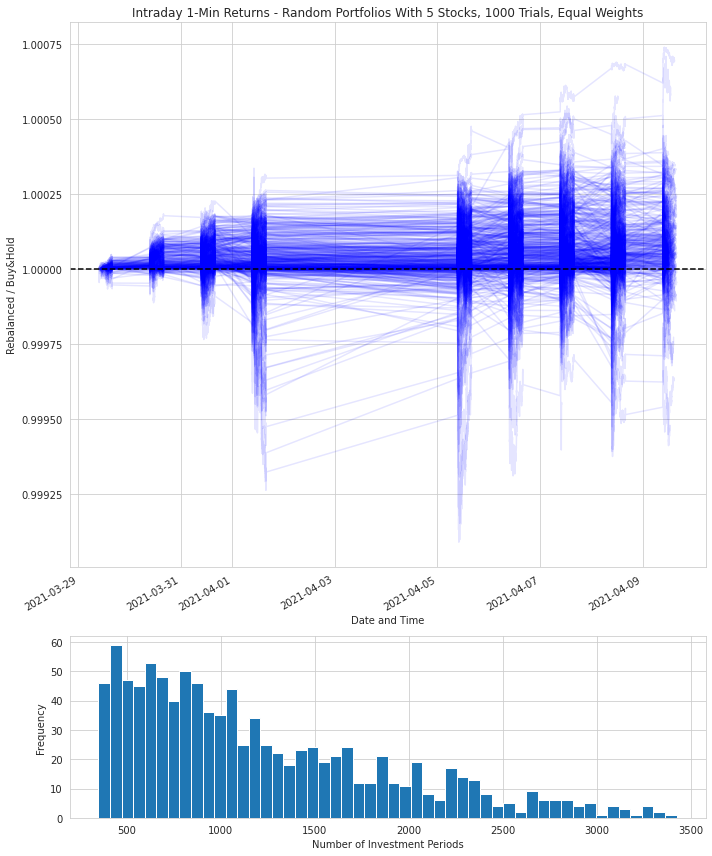

In [78]:
# Simulate and plot pandom portfolios with 5 stocks each.
sim_plot_portfolio_traces(returns=intraday_1min_returns,
                          returns_name=INTRADAY_1MIN_RETURNS,
                          num_stocks=5, num_trials=1000,
                          random_weights=False);

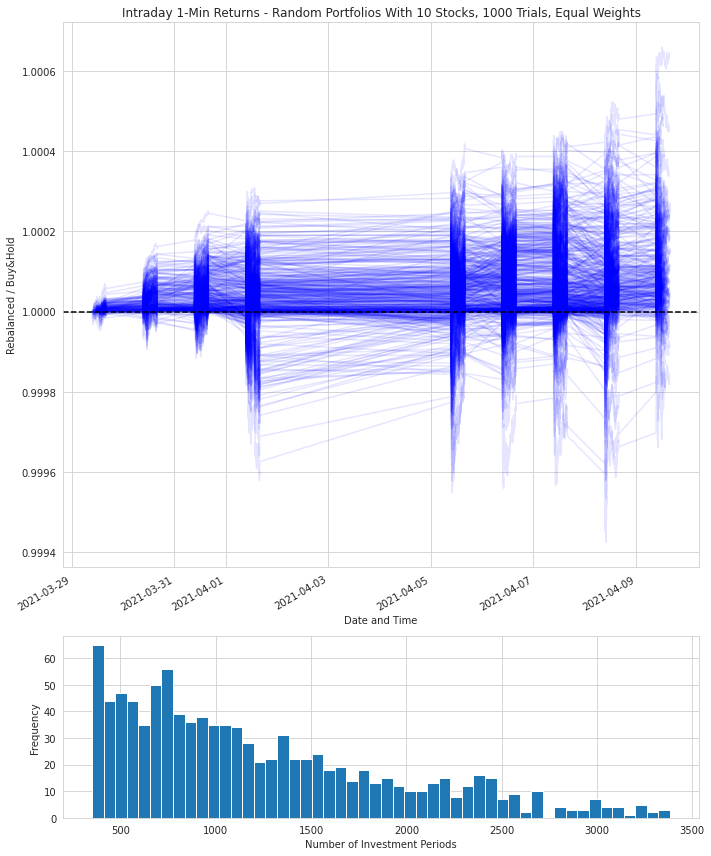

In [79]:
# Simulate and plot pandom portfolios with 10 stocks each.
sim_plot_portfolio_traces(returns=intraday_1min_returns,
                          returns_name=INTRADAY_1MIN_RETURNS,
                          num_stocks=10, num_trials=1000,
                          random_weights=False);

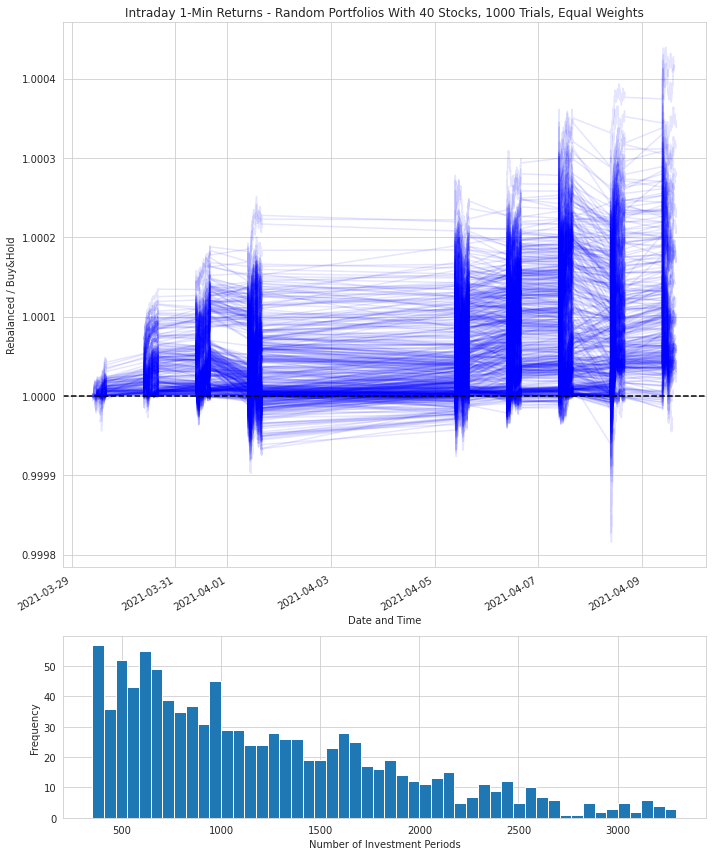

In [80]:
# Simulate and plot pandom portfolios with 40 stocks each.
sim_plot_portfolio_traces(returns=intraday_1min_returns,
                          returns_name=INTRADAY_1MIN_RETURNS,
                          num_stocks=40, num_trials=1000,
                          random_weights=False);

CPU times: user 37.4 s, sys: 288 ms, total: 37.7 s
Wall time: 36.4 s


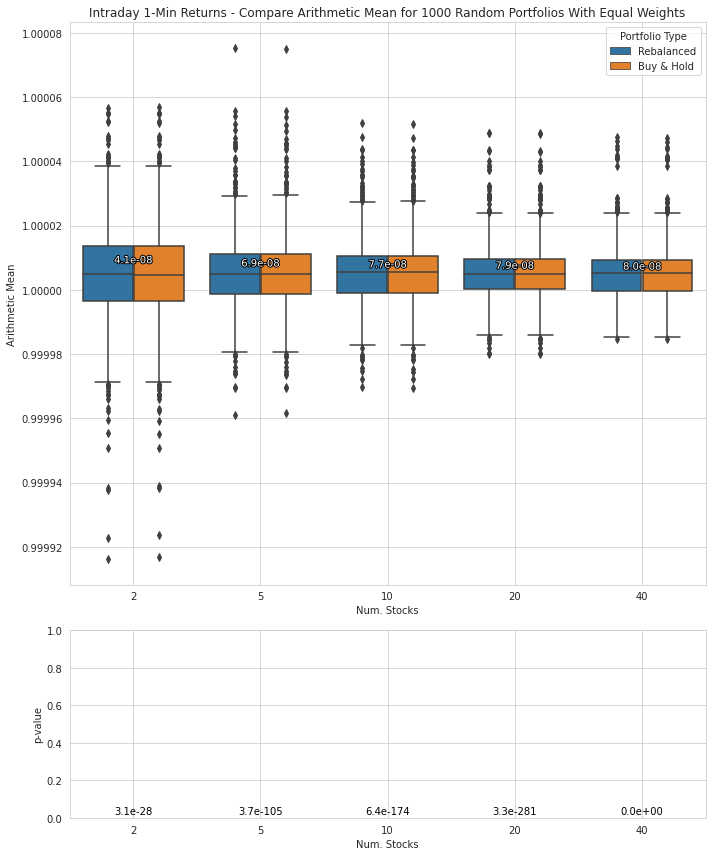

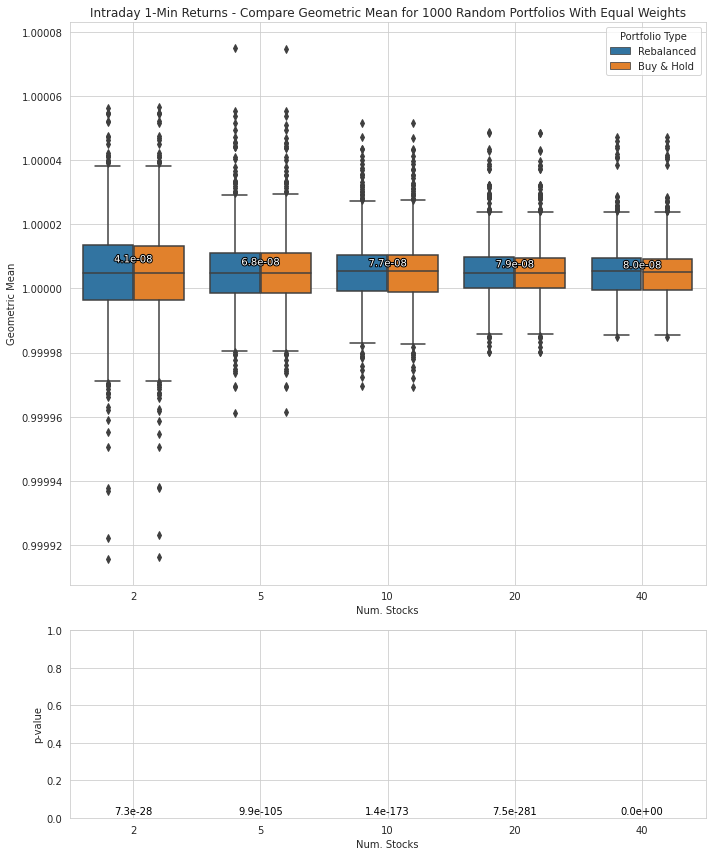

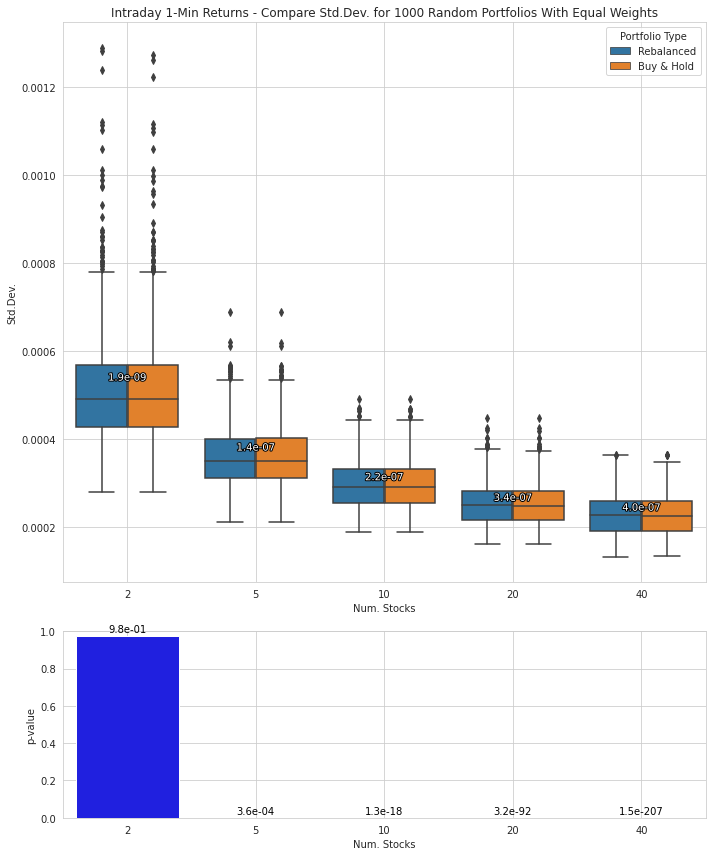

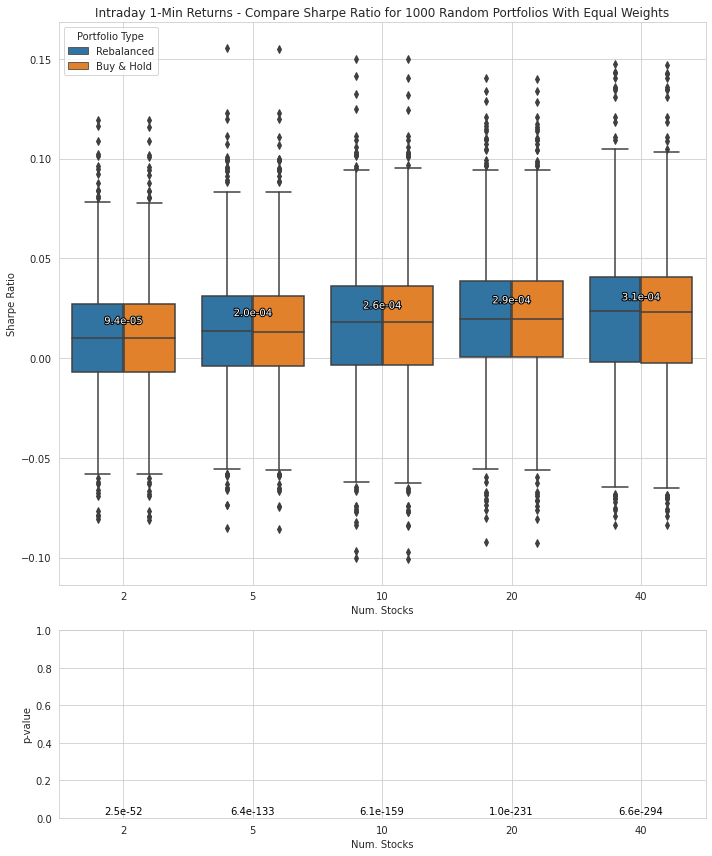

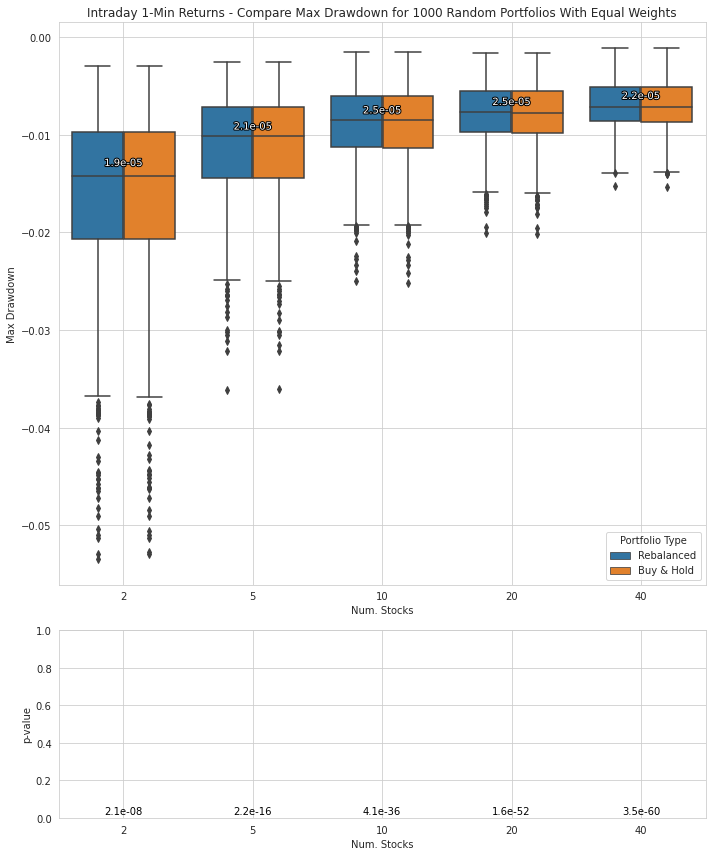

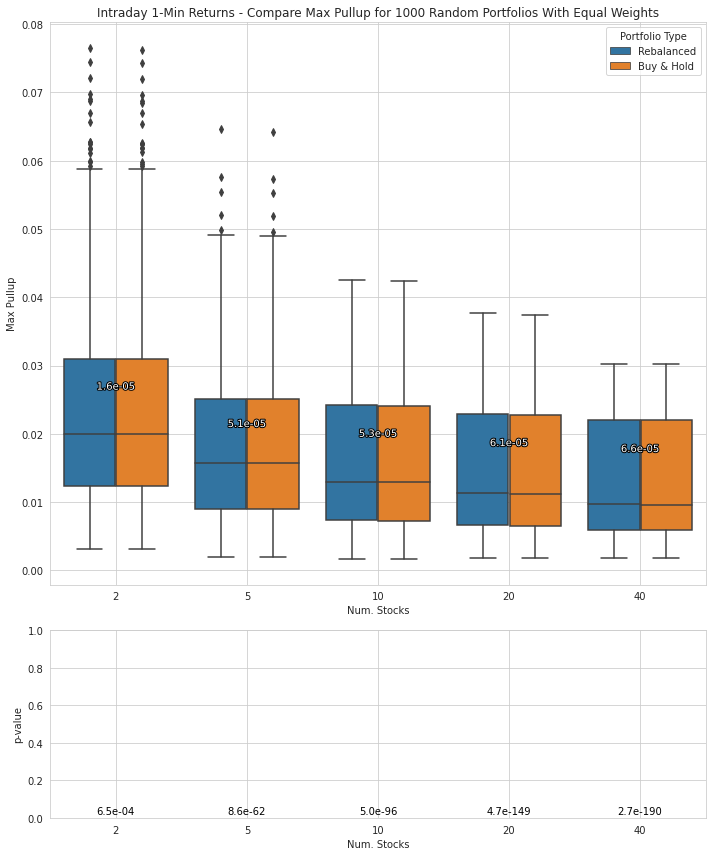

In [81]:
%%time
# Simulate random portfolios and plot all the statistics
# comparing the Rebalanced and Buy&Hold portfolios.
num_stocks = [2, 5, 10, 20, 40]
sim_plot_compare_all(returns=intraday_1min_returns,
                     returns_name=INTRADAY_1MIN_RETURNS,
                     num_stocks=num_stocks, num_trials=1000, 
                     random_weights=False)

## Intraday Returns 5-Min

Now make all the plots for intraday stock-returns with 5-minute intervals.

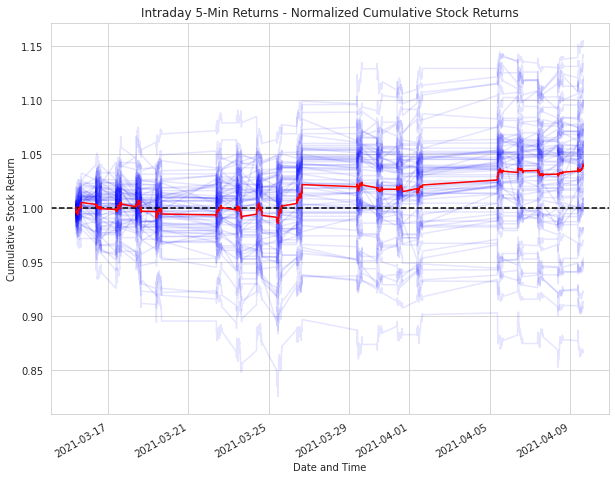

In [82]:
# Plot the normalized and cumulative returns of all stocks.
plot_all_stock_traces(returns=intraday_5min_returns,
                      returns_name=INTRADAY_5MIN_RETURNS);

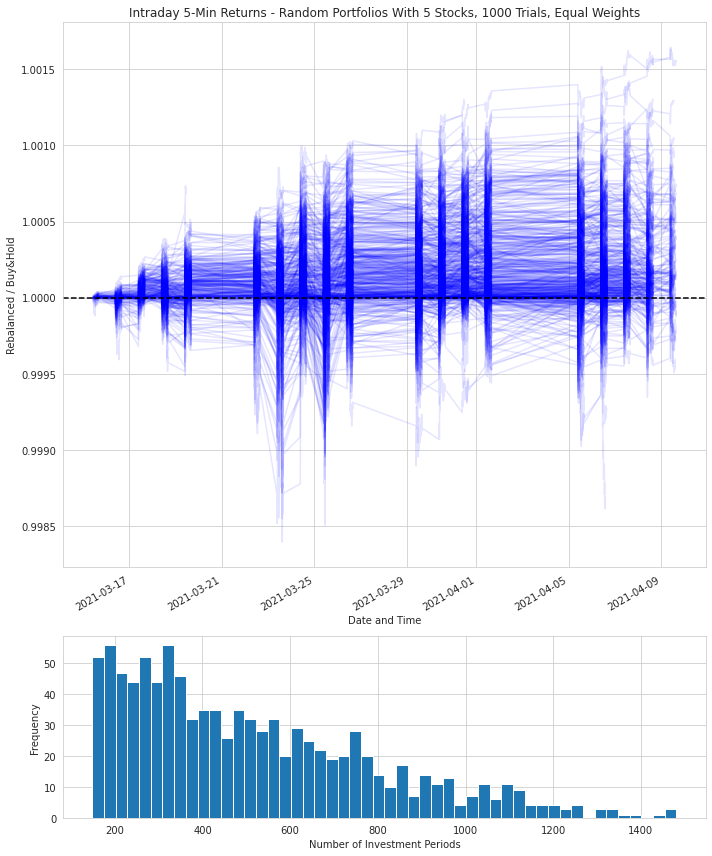

In [83]:
# Simulate and plot pandom portfolios with 5 stocks each.
sim_plot_portfolio_traces(returns=intraday_5min_returns,
                          returns_name=INTRADAY_5MIN_RETURNS,
                          num_stocks=5, num_trials=1000,
                          random_weights=False);

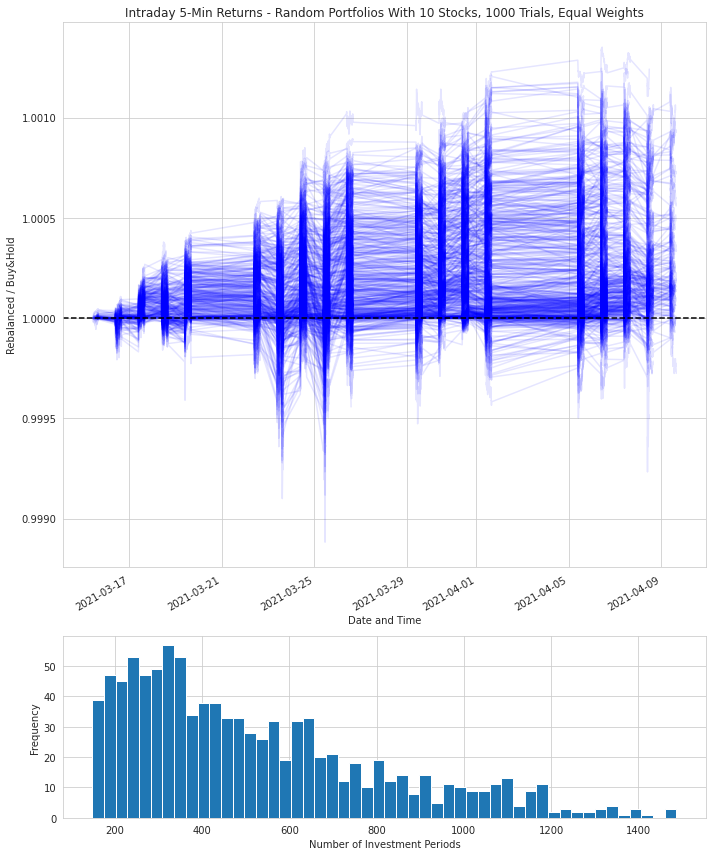

In [84]:
# Simulate and plot pandom portfolios with 10 stocks each.
sim_plot_portfolio_traces(returns=intraday_5min_returns,
                          returns_name=INTRADAY_5MIN_RETURNS,
                          num_stocks=10, num_trials=1000,
                          random_weights=False);

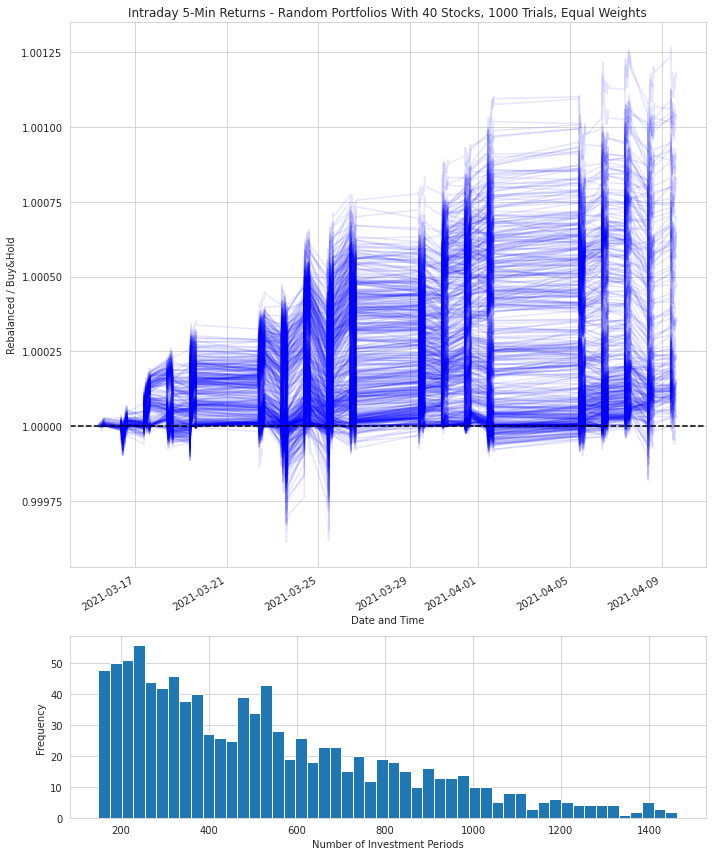

In [85]:
# Simulate and plot pandom portfolios with 40 stocks each.
sim_plot_portfolio_traces(returns=intraday_5min_returns,
                          returns_name=INTRADAY_5MIN_RETURNS,
                          num_stocks=40, num_trials=1000,
                          random_weights=False);

CPU times: user 34.3 s, sys: 564 ms, total: 34.9 s
Wall time: 33.7 s


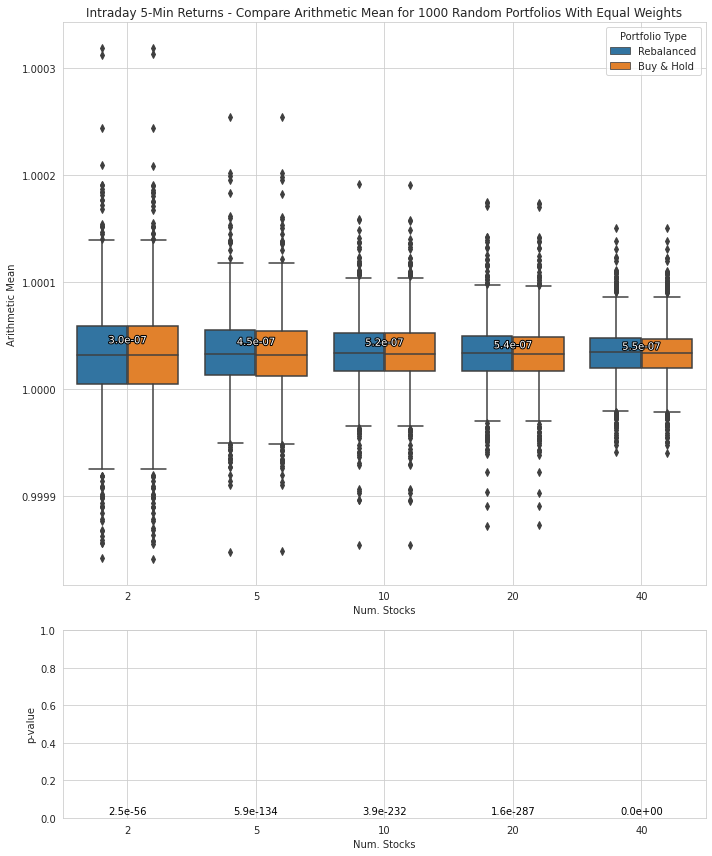

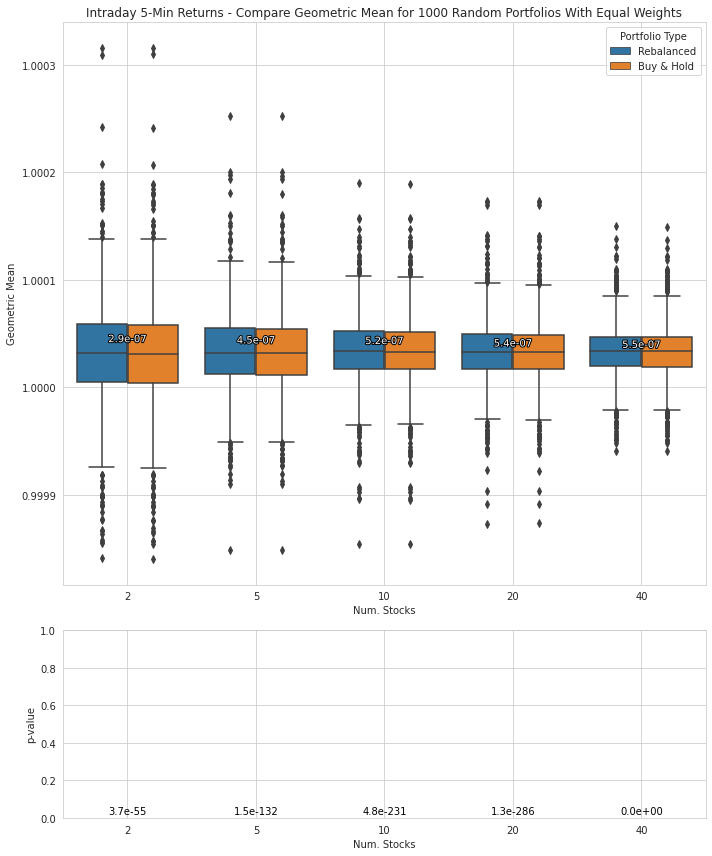

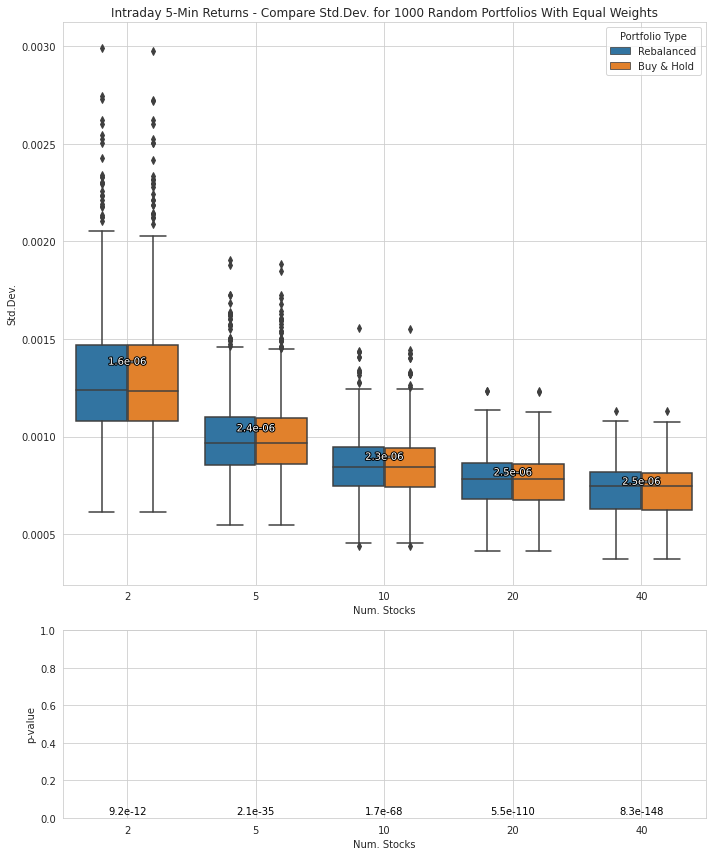

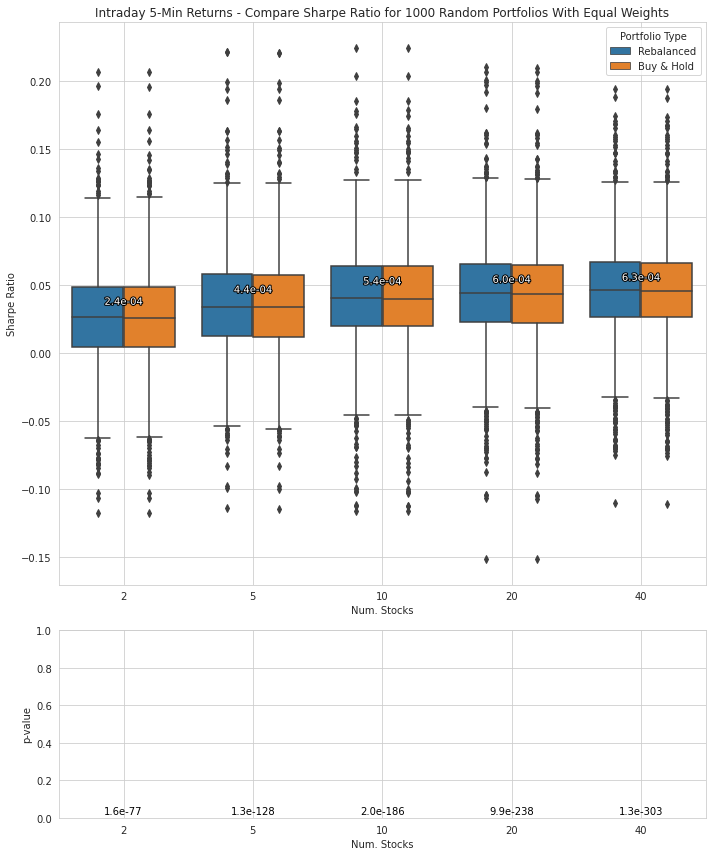

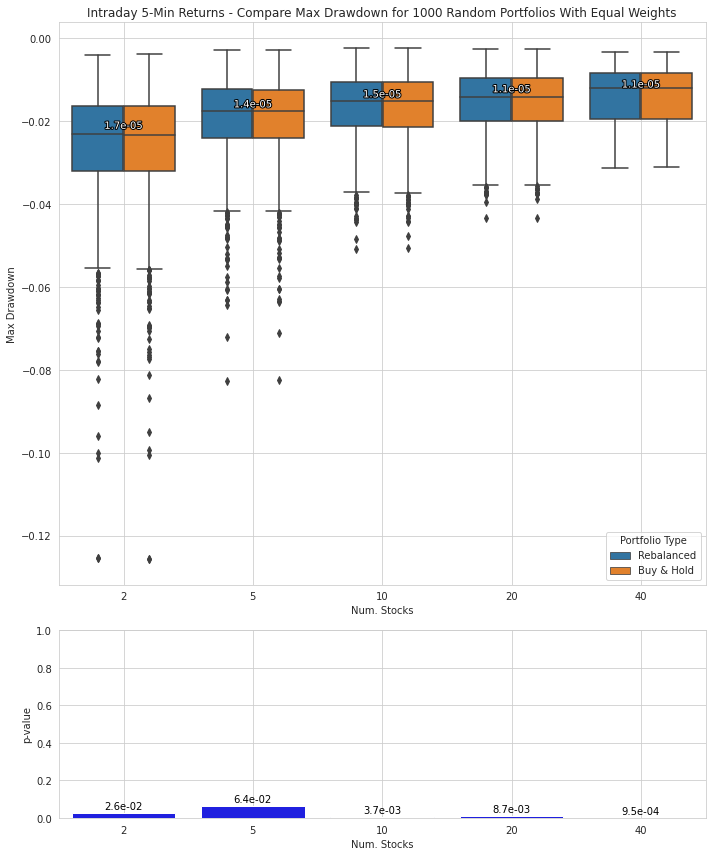

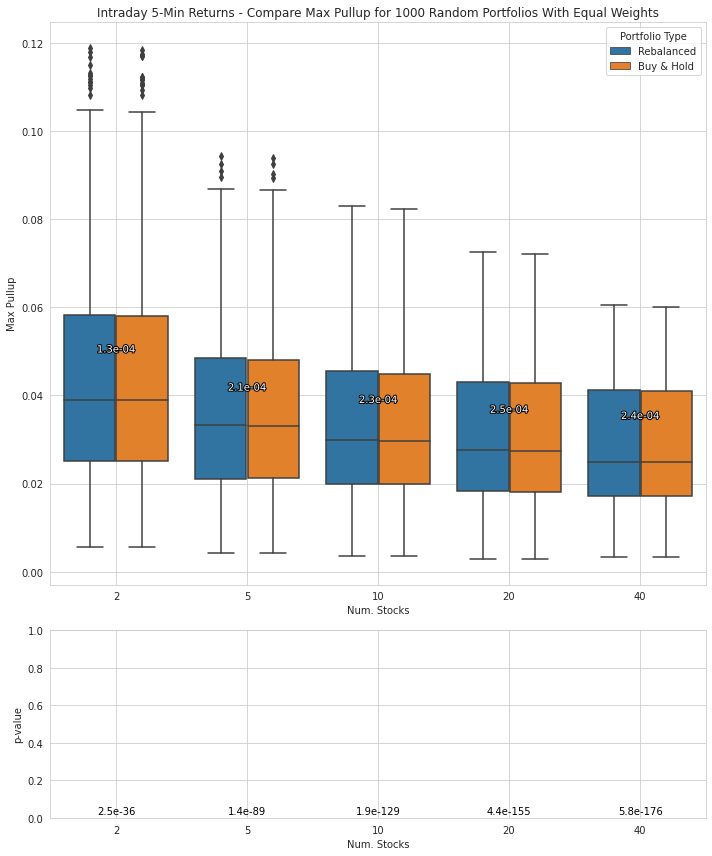

In [86]:
%%time
# Simulate random portfolios and plot all the statistics
# comparing the Rebalanced and Buy&Hold portfolios.
num_stocks = [2, 5, 10, 20, 40]
sim_plot_compare_all(returns=intraday_5min_returns,
                     returns_name=INTRADAY_5MIN_RETURNS,
                     num_stocks=num_stocks, num_trials=1000, 
                     random_weights=False)

## Plot Histograms For Return Correlations

Now compare the correlations for daily and intraday stock-returns. As we can see, the daily stock-returns are much more correlated than intraday stock-returns.

In [87]:
# List of common tickers for the daily and intraday stock-returns.
common_tickers = set(valid_tickers_daily)
common_tickers = common_tickers.intersection(set(valid_tickers_intraday_1min))
common_tickers = common_tickers.intersection(set(valid_tickers_intraday_5min))
common_tickers = list(common_tickers)

# Correlation method.
corr_method = 'spearman'

# Correlations of daily stock-returns.
corr_daily_returns = daily_returns[common_tickers].corr(method=corr_method)

# Correlations of intraday stock-returns.
corr_intraday_1min = intraday_1min_returns[common_tickers].corr(method=corr_method)
corr_intraday_5min = intraday_5min_returns[common_tickers].corr(method=corr_method)

# Flatten the correlation matrices into Pandas Series.
num_tickers = len(common_tickers)
triu_matrix = np.triu(np.ones(num_tickers, dtype=bool), k=1)
flat_corr_daily_returns = corr_daily_returns.where(triu_matrix).unstack()
flat_corr_intraday_1min = corr_intraday_1min.where(triu_matrix).unstack()
flat_corr_intraday_5min = corr_intraday_5min.where(triu_matrix).unstack()

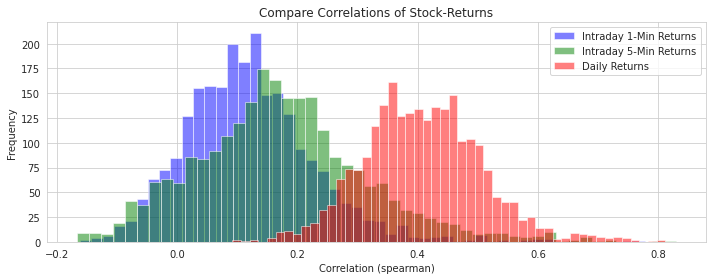

In [88]:
# Create new figure for plotting.
fig, ax = plt.subplots(figsize=figsize_small)

# Create title.
title = f'Compare Correlations of Stock-Returns'

# Plot histogram for intraday 1-min stock-returns.
flat_corr_intraday_1min.plot(kind='hist', bins=50, alpha=0.5,
                             color='blue', ax=ax,
                             label=INTRADAY_1MIN_RETURNS);

# Plot histogram for intraday 5-min stock-returns.
flat_corr_intraday_5min.plot(kind='hist', bins=50, alpha=0.5,
                             color='green', ax=ax,
                             label=INTRADAY_5MIN_RETURNS);

# Plot histogram for daily stock-returns.
flat_corr_daily_returns.plot(kind='hist', bins=50, alpha=0.5,
                             color='red', ax=ax,
                             label=DAILY_RETURNS);

# Set the plot's title, etc.
ax.set_title(title)
ax.legend()
ax.set_xlabel(f'Correlation ({corr_method})')

# Adjust padding.
fig.tight_layout()

# Save the figure to disk.
filename = os.path.join(path_plots, title + '.svg')
fig.savefig(filename, bbox_inches='tight')

## License (MIT)

Copyright (c) 2021 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.